<a href="https://colab.research.google.com/github/hirohitoo/anapal/blob/main/SimpleRead_PALscans_R31_20220315tr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

R31


dataset_list=delayscan29
prefix_list=
Energy_list=(291,294)
Repeat_list=(0,1)
Region_list=(0,160)  np.uniq(Region_list)=# of regions
0-79 Region0, Repeat0  
80-159 Region0, Repeat1  
160-24080 Region1, Repeat0  
24081-48000 Region1, Repeat1
48001-48299 Region1, Repeat2 (aborted)

delayscan31
286
0-79 Region0, Repeat0  
80-489 Region0, Repeat1  
491-24080 Region1, Repeat0  
24081-48000 Region1, Repeat1
48001-48299 Region1, Repeat2 (aborted)


delayscan29
291,294
0-490 Region0
491- Region1 Rep 0, 1, 2, 3
 (aborted)


In [13]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
!ls drive/MyDrive/PALtraining/Notebook

PALanaED.ini  SimpleRead_PALscans_R31_20220315.ipynb


In [24]:
#Change home directory
%cd drive/MyDrive/PALtraining/Notebook

/content/drive/MyDrive/PALtraining/Notebook


In [25]:
!pwd

/content/drive/MyDrive/PALtraining/Notebook


In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import glob #pattern package to find filename
import pickle
import itertools
import inspect
import scipy as sp
import glob

#from datetime import date
#today = date.today()

In [22]:
#Read Config file
CONFIG_FILE="drive/MyDrive/PALtraining/Notebook/PALanaED.ini"

import configparser
config = configparser.ConfigParser()
config.sections()
#config.read('PALanaE.ini')
config.read(CONFIG_FILE)
sections = config.sections()
print(sections)
for x in sections:
    #print(sections.index(x),x)
    print(x)

['PALana', 'TEY-hbn-3ps-65%%-escan442', 'TEY-hbn--0.27ps-65%%-escan441', 'TEY-hbn-300eV-65%%-dscan440', 'TEY-hbn-296.25eV-65%%-dscan439', 'TEY-hbn-299.25eV-65%%-dscan438', 'TEY-hbn-298.4eV-65%%-dscan437', 'TEY-hbn-1ps-65%%-escan436', 'TEY-hbn--1ps-65%%-escan435', 'TEY-hbn-298.4eV-65%%-dscan434', 'TEY-hbn--0.4ps-65%%-escan433', 'TEY-hbn-1ps-65%%-escan432', 'TEY-hbn--0.2ps-65%%-escan431', 'TEY-hbn-0.4ps-65%%-escan430', 'TEY-hbn--0.6ps-65%%-escan429', 'TEY-hbn-298.4eV-65%%-dscan428', 'TEY-hbn-0.2ps-65%%-escan427', 'TEY-hbn-0ps-65%%-escan426', 'TEY-hbn--0.2ps-65%%-escan425', 'TEY-hbn--0.4ps-65%%-escan424', 'TEY-hbn-1500ps-65%%-escan423', 'TEY-hbn-130ps-65%%-escan422', 'TEY-hbn-6ps-65%%-escan421', 'TEY-hbn-299.25eV-65%%-dscan420', 'TEY-hbn-301eV-65%%-dscan419', 'TEY-hbn-300.5eV-65%%-dscan418', 'TEY-hbn-300eV-65%%-dscan417', 'TEY-hbn-299.75eV-65%%-dscan416', 'TEY-hbn-299.50eV-65%%-dscan415', 'TEY-hbn-299.25eV-65%%-dscan414', 'TEY-hbn-nolaser-escan413', 'TEY-hbn-299eV-65%%-dscan412', 'TEY-hbn

In [21]:
#function for fitting
#def func1(x,a,b,c):
#    return a*x + b + 0*c*x**3

def delaymm2delayps(delaymm,time0):
    delayps=[]
    delayps=(delaymm-time0)/1000*2/299792458*1e12
    return delayps


def returnlistofelements(filename):
    a=open(filename,'r')
    b=a.readline().split(',')
    a.close()
    return b

def converttimestamp(TimestampString):
   # timestampsubsecs = []
    timestampsecs = []
    timestampsmin = []
    timestampshour = []
    timestampsday = []
    timestampsecsabs = []
    for i in range(len(TimestampString)):
        #timestampmsecs.append(np.float64(TimestampString[i].split(' ')[-2].split(':')[0]))
        timestampsecs.append(np.float64(TimestampString[i].split(' ')[-2].split(':')[-1]))
        timestampsmin.append(np.float64(TimestampString[i].split(' ')[-2].split(':')[-2]))
        timestampshour.append(np.float64(TimestampString[i].split(' ')[-2].split(':')[-3]))
        timestampsday.append(np.float64(TimestampString[i].split(' ')[-3].split('-')[-1]))
        timestampsecsabs.append(24*3600*timestampsday[i]+3600*timestampshour[i]+60*timestampsmin[i]+timestampsecs[i])
    return timestampsecsabs, timestampshour, timestampsmin, timestampsecs



In [ ]:
def PALdataset_to_CSV(input_f):
    config = configparser.ConfigParser()
    #config.sections()
    config.read(CONFIG_FILE)
    #sections = config.sections()
    print(input_f,'will be processed.')  #section name
    dataset=config.get(input_f,'dataset')
    prefix=config.get(input_f,'prefix')
    prefix=prefix+dataset
    print('Files in',prefix,'will be loaded.')
    EnergyOfInterest=config.get(input_f,'EnergyOfInterest').split('\n')
    DelayOfInterest=config.get(input_f,'DelayOfInterest').split('\n')
    Repeat_list=config.get(input_f,'Repeat_list')
    LOFFpos=config.get(input_f,'LOFFpos')
    t0pos=config.get(input_f,'t0pos')
    datasetnumber=int(config.get(input_f,'datasetnumber'))

    Var_NegativeDelayRef=config.get(input_f,'Var_NegativeDelayRef')

    Flg_EnergyScan=bool(int(config.get(input_f,'Flg_EnergyScan')))
    Flg_DelayScan=bool(int(config.get(input_f,'Flg_DelayScan')))
    Flg_ModulationScan=bool(int(config.get(input_f,'Flg_ModulationScan')))
    Flg_NegativeDelayRef=bool(int(config.get(input_f,'Flg_NegativeDelayRef')))

    Flg_EnergyOffset=bool(int(config.get(input_f,'Flg_EnergyOffset')))
    Flg_DarkOffsetI0=bool(int(config.get(input_f,'Flg_DarkOffsetI0')))
    Flg_DarkOffsetI1=bool(int(config.get(input_f,'Flg_DarkOffsetI1')))

    Var_EnergyOffset=float(config.get(input_f,'Var_EnergyOffset'))
    Var_DarkOffsetI0=float(config.get(input_f,'Var_DarkOffsetI0'))
    Var_DarkOffsetI1=float(config.get(input_f,'Var_DarkOffsetI1'))

    Flg_ApplyI0NotchFilter=bool(config.get(input_f,'Flg_ApplyI0NotchFilter'))
    Var_I0_NotchFilter_min=float(config.get(input_f,'Var_I0_NotchFilter_min'))
    Var_I0_NotchFilter_max=float(config.get(input_f,'Var_I0_NotchFilter_max'))

#Define the condition for Laser ON, Laser OFF
    if Flg_NegativeDelayRef==True:
        LONQuery = '(DelayStagePos >'+str(Var_NegativeDelayRef)+')'
        LOFFQuery='(DelayStagePos =='+str(Var_NegativeDelayRef)+')'
    if Flg_ModulationScan==True:
        LONQuery = '(TimestampAbsSec%12 ==6)'
        LOFFQuery = '(TimestampAbsSec%12 ==0)'
        print('LONQuery',LONQuery)
        print('LOFFQuery',LOFFQuery)



    import glob
    import numpy as np
    import itertools
    import pandas as pd
    import itertools

    print(prefix+'/*MCP*.*')
    I0_FileNames = glob.glob(prefix+'/*MCP*.*')
    #print(I0_FileNames)
    I1_FileNames = []
    ShotList = []

    for i in range(len(I0_FileNames)):
        FN = str(I0_FileNames[i])
        I1_FileNames.append(FN.replace('MCP_',''))
        a=open(I1_FileNames[i],'r')
        b=a.readline().split(',')
        numShots =int((len(returnlistofelements(I1_FileNames[i]))-3)/2) #int((np.shape(pd.read_csv(I1_FileNames[0]))[1]-3)/2)
        ShotList.append(numShots)

#print(ShotList)
    print('Number of Shots/File:',numShots)

    Mono = []
    Undulator = []
    DelayStagePos = []
    Delay = []
    Timestamp = []
    I0_int = []
    I1_int = []
    RunNr = []
    dataList = []
    LaserStatus = []
    RepeatNr = []
    ShotsPerSet = []

    for r in range(len(I1_FileNames)):
        I1fn = I1_FileNames[r]
        I0fn = I0_FileNames[r]
        numShots = ShotList[r]

        I1 = returnlistofelements(I1fn) #pd.read_csv(I1fn,header=None,names = ColNam,engine='python')
        I0 = returnlistofelements(I0fn) #pd.read_csv(I0fn,header=None,names = ColNam, engine='python')

        if len(I1)<3 or len(I0)<3 :
            continue

        monoforfile=float(I1[0])
        undulatorforfile=float(I1[1])
        restdata=I1[3:None]
        restdataI0=I0[3:None]

        timestampforfile=restdata[0::2]
        i1forfile=restdata[1::2]
        i0forfile=restdataI0[1::2]

        delay_stage_position=float(I0fn.split('_')[-3][2:None])
        DelayStagePos.append([delay_stage_position]*numShots)
        Mono.append([monoforfile]*numShots)
        Undulator.append([undulatorforfile]*numShots)
    #ShotsPerSet.append(numShots)

        Timestamp.append(timestampforfile)
        I1_int.append(i1forfile)
        I0_int.append(i0forfile)

        timelist=I0fn.split('/')[-1].split('_')[0].split('-')# I0fn.split('/')[-1].split('_')[1].split('\\')[1].split('-')
        timelist=[float(i) for i in timelist]
        timing=3600*timelist[0]+60*timelist[1]+timelist[2]
        timetrace=np.linspace(0,2,numShots)
    #RunNr.append(timetrace+timing)
        RunNr.append(timestampforfile)
    #print(I0fn.split('_')[-2])
        for j in range(numShots):
            LaserStatus.append(float(I0fn.split('_')[-2][5:6]))
            RepeatNr.append(float(I0fn.split('_')[-1][3:4]))
    #print(I0fn.split('_')[-1])
    #print(RepeatNr)
####
####
####
    Timestamp=list(itertools.chain(*Timestamp))
    Mono=list(itertools.chain(*Mono))
    DelayStagePos=list(itertools.chain(*DelayStagePos))
    Undulator=list(itertools.chain(*Undulator))
    I1_int=list(itertools.chain(*I1_int))
    I0_int=list(itertools.chain(*I0_int))
    RunNr=list(itertools.chain(*RunNr))
    I1_int=[float(i) for i in I1_int]
    I0_int=[float(j) for j in I0_int]
    keys = {'DelayStagePos':DelayStagePos,'Mono':Mono, 'Undulator':Undulator,'Timestamp':Timestamp,'I0_int':I0_int, 'I1_int':I1_int, 'RunNumber':RunNr, 'LaserStatus':LaserStatus, 'RepeatNumber':RepeatNr}

#EDFall['Timestamp']=EDFall['Timestamp'].astype(str).astype(int)

    EDFall = pd.DataFrame(data=keys)
#EDFall['TimestampAbsSec'] = converttimestamp(EDFall.Timestamp)[0]
    EDFall['TimestampAbsSec'] = EDFall.Timestamp.astype(str).astype(int)
    EDFall['Energy'] = EDFall.Undulator


    EDFall=EDFall.sort_values(by=['TimestampAbsSec']).reset_index(drop=True)
#    print('Numer of Elements/Column:',EDFall.shape[0])

#Add Regions
    Region_a = []
    Region_a =1
    EDFall['Region']=Region_a
#print(EDF)

# Add the delay in ps to the data frame
    EDFall['Delay_ps'] = (EDFall.DelayStagePos - float(t0pos))*20/3
    Delay_ps=np.unique(EDFall.Delay_ps)
    DelayStagePos_mm=np.unique(EDFall.DelayStagePos)
    #print('Delay_mm:',np.unique(EDFall.DelayStagePos))
    #print('Delay_ps:',np.unique(EDFall.Delay_ps))
    print('Flg_DelayScan:',Flg_DelayScan)
    print('Flg_EnergyScan:',Flg_EnergyScan)
    print('Flg_ModulationScan:',Flg_ModulationScan)
    print('Flg_NegativeDelayRef:',Flg_NegativeDelayRef)

#    print('Region:',np.unique(EDFall.Region))
    #print('Energy:',np.unique(EDFall.Undulator))
    print('Repeat:',np.unique(EDFall.RepeatNumber))
    if DelayOfInterest[0] == 'True':
        DelayOfInterest=np.unique(EDFall.DelayStagePos)
#print(DelayOfInterest)
    if EnergyOfInterest[0] == 'True':
        EnergyOfInterest=np.unique(EDFall.Energy)
#else:
#    EnergyOfInterest=
#    print('EnergyOfInterest',EnergyOfInterest)
# Save Data Frame
#EDFall.to_pickle(prefix+'/'+dataset+'.pkl')
#print('Data Frame was saved as','../ana/'+dataset+'.pkl')

    #Generate sub-dataframe, which matches Delay_key & Energy_key & Repeat_key
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
#from mpl_toolkits import mplot3d

    figure_count=0

    print('Is this Delay scan?',Flg_DelayScan)
    Delay_key='DelayStagePos == '+str(DelayOfInterest[0])

    print('Is this Energy scan?',Flg_EnergyScan)
    Energy_key='Energy =='+str(EnergyOfInterest)
    Repeat_key='RepeatNumber == 0.0'#+str(Repeat_list[0])
#Repeat_key='RepeatNumber in '+str(Repeat_list)

    EnergyScan=True

    if Flg_EnergyScan==True:
#Activate this for energy scan
        print('2 Flg_EnergyScan=True')
        #print('2 Delay_key:',Delay_key)
        EDFsub=EDFall.query(Delay_key).reset_index(drop=True)
#    EDFsub=EDFall.query(Energy_key).reset_index(drop=True)
        print('2 ',Delay_key,EDFsub.shape[0],'/',EDFall.shape[0],'matched.')

#    xmax=EDFsub.shape[0]
#print(xmax)

#EDFsub=EDFall
    if Flg_DelayScan==True:
#Activate this for delay scan
        print('3 Flg_DelayScan=True')
        #print('3 Energy_key:',Energy_key)
        EDFsub=EDFall.query(Energy_key).reset_index(drop=True)
        print('3 ',Energy_key,EDFsub.shape[0],'/',EDFall.shape[0],'matched.')
#        print('3 Delay_ps:',EDFall['Delay_ps'])
    #xmax=EDFsub.shape[0]
    #print(xmax)

#print(EDFsub.shape[0],'/',EDFall.shape[0],'matches',Energy_key)

    DelayPoint = []
    xmax=EDFsub.shape[0]
#print(xmax)
    y=0
    for x in EDFsub.index:
        if x==EDFsub.index.min():
            y=0
        else:
            w=EDFsub.DelayStagePos.values[x]
            v=EDFsub.DelayStagePos.values[x-1]
            if EDFsub.DelayStagePos.values[x-1]!=EDFsub.DelayStagePos.values[x]:
                y=y+1
        DelayPoint.append(y)
    EDFsub['DelayPoint']=DelayPoint

    EnergyPoint = []
    xmax=EDFsub.shape[0]
    y=0
    for x in EDFsub.index:
        if x==EDFsub.index.min():
            y=0
        else:
            w=EDFsub.Energy.values[x]
            v=EDFsub.Energy.values[x-1]
            if EDFsub.Energy.values[x-1]!=EDFsub.Energy.values[x]:
                y=y+1
        EnergyPoint.append(y)
    EDFsub['EnergyPoint']=EnergyPoint

#print(Repeat_key)
    EDFsub=EDFsub.query(Repeat_key)
    print(Repeat_key,EDFsub.shape[0],'/',EDFall.shape[0],'matched.')

#Separate LON and LOFF here
    print('Is this Modulaiton scan?',Flg_ModulationScan)
    if Flg_ModulationScan==True:
        EDFsubLON=EDFsub.query(LONQuery)
        print('LaserON',LONQuery,EDFsubLON.shape[0],'/',EDFsub.shape[0],'matched.')
        EDFsubLOFF=EDFsub.query(LOFFQuery)
        print('LaserOFF',LOFFQuery,EDFsubLOFF.shape[0],'/',EDFsub.shape[0],'matched.')

    if Flg_NegativeDelayRef==True:
        EDFsubLON=EDFall.query(LONQuery)
        print('LaserON',LONQuery,EDFsubLON.shape[0],'/',EDFall.shape[0],'matched.')
        EDFsubLOFF=EDFall.query(LOFFQuery)
        print('LaserOFF',LOFFQuery,EDFsubLOFF.shape[0],'/',EDFall.shape[0],'matched.')

        #Generate XAS
#I1/I0
#(I1_LON/I0_LON)/(I1_LOFF/I0_LOFF)-1

    EDFsubI0_intmean_a=[]
    EDFsubI1_intmean_a=[]
    EDFsubI0LOFF_intmean_a=[]
    EDFsubI1LOFF_intmean_a=[]
    EDFsubI0LON_intmean_a=[]
    EDFsubI1LON_intmean_a=[]
    Energy_a=[]
    Delay_a=[]
    Xas_a=[]
    XasLOFF_a=[]
    XasLON_a=[]
    DeltaXas_a=[]
    DiffXas_a=[]

    if Flg_EnergyOffset==False:
        Var_EnergyOffset=0

    if Flg_DarkOffsetI0==False:
        Var_DarkOffsetI0=0

    if Flg_DarkOffsetI1==False:
        Var_DarkOffsetI1=0

#EnergyScan=True
    if Flg_EnergyScan==True:
        for w in EnergyOfInterest:
            loop_Energy_key='Energy =='+str(w)
        #offset=(EDFsub.I0_int_db.mean())
            EDFsubI0_intmean_a.append((EDFsub.query(loop_Energy_key).I0_int-Var_DarkOffsetI0).sum())
            EDFsubI1_intmean_a.append((EDFsub.query(loop_Energy_key).I1_int-Var_DarkOffsetI1).sum())
            Energy_a.append(w-Var_EnergyOffset)
            Delay_a.append((float(DelayOfInterest[0])-float(t0pos))*2/3E11*1E12)
            Xas_a.append((EDFsub.query(loop_Energy_key).I1_int-Var_DarkOffsetI1).sum()/(EDFsub.query(loop_Energy_key).I0_int-Var_DarkOffsetI0).sum())
            keys = {'Energy'+str(datasetnumber):Energy_a,'Xas'+str(datasetnumber):Xas_a,
                'Delay'+str(datasetnumber):Delay_a,'I0mean'+str(datasetnumber):EDFsubI0_intmean_a,
                'I1mean'+str(datasetnumber):EDFsubI1_intmean_a}

            if Flg_ModulationScan==True:
                EDFsubI0LOFF_intmean_a.append((EDFsub.query(LOFFQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI0).sum())
                EDFsubI1LOFF_intmean_a.append((EDFsub.query(LOFFQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum())
                EDFsubI0LON_intmean_a.append((EDFsub.query(LONQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI0).sum())
                EDFsubI1LON_intmean_a.append((EDFsub.query(LONQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum())
                XasLOFF_a.append((EDFsub.query(LOFFQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFsub.query(LOFFQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI0).sum())
                XasLON_a.append((EDFsub.query(LONQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFsub.query(LONQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI0).sum())
                DiffXas_a.append(((EDFsub.query(LONQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFsub.query(LONQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI1).sum())-
                           ((EDFsub.query(LOFFQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFsub.query(LOFFQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI1).sum()))


                DeltaXas_a.append(((EDFsub.query(LONQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFsub.query(LONQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI1).sum())/
                           ((EDFsub.query(LOFFQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFsub.query(LOFFQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI1).sum()))

                keys = {'Energy'+str(datasetnumber):Energy_a,'DeltaXas'+str(datasetnumber):DeltaXas_a,
                        'DiffXas'+str(datasetnumber):DiffXas_a,
                    'XasLOFF'+str(datasetnumber):XasLOFF_a,'XasLON'+str(datasetnumber):XasLON_a,
                    'Delay_ps'+str(datasetnumber):Delay_a,
                    'I0LOFFmean'+str(datasetnumber):EDFsubI0LOFF_intmean_a,
                    'I1LOFFmean'+str(datasetnumber):EDFsubI1LOFF_intmean_a,
                    'I0LONmean'+str(datasetnumber):EDFsubI0LON_intmean_a,
                    'I1LONmean'+str(datasetnumber):EDFsubI1LON_intmean_a}
            if Flg_NegativeDelayRef==True:
                EDFsubI0LOFF_intmean_a.append((EDFall.query(LOFFQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI0).sum())
                EDFsubI1LOFF_intmean_a.append((EDFall.query(LOFFQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum())
                EDFsubI0LON_intmean_a.append((EDFall.query(LONQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI0).sum())
                EDFsubI1LON_intmean_a.append((EDFall.query(LONQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum())
                XasLOFF_a.append((EDFall.query(LOFFQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFall.query(LOFFQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI0).sum())
                XasLON_a.append((EDFall.query(LONQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFall.query(LONQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI0).sum())
                DiffXas_a.append(((EDFall.query(LONQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFall.query(LONQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI1).sum())-
                           ((EDFall.query(LOFFQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFall.query(LOFFQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI1).sum()))
                DeltaXas_a.append(((EDFall.query(LONQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFall.query(LONQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI1).sum())/
                           ((EDFall.query(LOFFQuery+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFall.query(LOFFQuery+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI1).sum()))

                keys = {'Energy'+str(datasetnumber):Energy_a,'DeltaXas'+str(datasetnumber):DeltaXas_a,
                        'DiffXas'+str(datasetnumber):DiffXas_a,

                    'XasLOFF'+str(datasetnumber):XasLOFF_a,'XasLON'+str(datasetnumber):XasLON_a,
                    'Delay_ps'+str(datasetnumber):Delay_a,
                    'I0LOFFmean'+str(datasetnumber):EDFsubI0LOFF_intmean_a,
                    'I1LOFFmean'+str(datasetnumber):EDFsubI1LOFF_intmean_a,
                    'I0LONmean'+str(datasetnumber):EDFsubI0LON_intmean_a,
                    'I1LONmean'+str(datasetnumber):EDFsubI1LON_intmean_a}

            #print(keys)
        #print('Energy scan',DiffXas_a)
        newDF=pd.DataFrame(keys)
#        print(newDF)


#    for w in EnergyOfInterest:
#        loop_Energy_key='Energy =='+str(w)




#    for w in DelayOfInterest:
#        loop_Energy_key='Delay =='+str(w)
#print(EnergyOfInterest)
#print(newDF)
#    plt.scatter(EDFall.Energy,EDFall.I0_int,c='r') #I1
#    plt.show()
#    plt.figure
#    plt.scatter(EDFall.Energy,EDFall.I1_int,c='r') #I0
#    plt.show()
#    plt.figure
#plt.scatter(newDF.Energy,newDF.I1mean/newDF.I0mean,c='r')
#plt.show()
#Plot and Save Energy scan
        if Flg_ModulationScan==True or Flg_NegativeDelayRef==True:
        #Diffetential XAS
            plt.plot(newDF['Energy'+str(datasetnumber)],newDF['DiffXas'+str(datasetnumber)],c='r')
            plt.savefig(prefix+'/../'+str(datasetnumber)+'dfxas.png')
            plt.show()
            plt.figure
        #Delta XAS
            plt.plot(newDF['Energy'+str(datasetnumber)],newDF['DeltaXas'+str(datasetnumber)],c='r')
            plt.savefig(prefix+'/../'+str(datasetnumber)+'dlxas.png')
            plt.show()
            plt.figure
        else:
        #XAS
            plt.plot(newDF['Energy'+str(datasetnumber)],newDF['Xas'+str(datasetnumber)],c='r')
            plt.savefig(prefix+'/../'+str(datasetnumber)+'xas.png')
            plt.show()
            plt.figure

        srt_datasetnumber=str(datasetnumber)
        print(prefix+'/'+str(datasetnumber)+'.csv')
        newDF.to_csv(prefix+'/../'+str(datasetnumber)+'.csv',index=False)
        print('Data Frame was saved as',prefix+'/../'+str(datasetnumber)+'.csv')
#    print(EDFall)
#Flg_DelayScan==True:
    elif Flg_DelayScan==True:
        print('DelayOfInterest',DelayOfInterest)
        for w in DelayOfInterest:
            loop_Delay_key='DelayStagePos =='+str(w)
        #offset=(EDFsub.I0_int_db.mean())
            EDFsubI0_intmean_a.append((EDFsub.query(loop_Delay_key).I0_int-Var_DarkOffsetI0).mean())
            EDFsubI1_intmean_a.append((EDFsub.query(loop_Delay_key).I1_int-Var_DarkOffsetI1).mean())
            Energy_a.append(EnergyOfInterest)
            Delay_a.append((float(w)-float(t0pos))*2/3E11*1E12)
            Xas_a.append((EDFsub.query(loop_Delay_key).I1_int-Var_DarkOffsetI1).sum()/(EDFsub.query(loop_Delay_key).I0_int-Var_DarkOffsetI0).sum())
            keys = {'DelayStagePos':Delay_a,'Xas'+str(datasetnumber):Xas_a,'I0mean':EDFsubI0_intmean_a, 'I1mean':EDFsubI1_intmean_a}

            if Flg_ModulationScan==True:
                EDFsubI0LOFF_intmean_a.append((EDFsub.query(LOFFQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI0).sum())
                EDFsubI1LOFF_intmean_a.append((EDFsub.query(LOFFQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum())
                EDFsubI0LON_intmean_a.append((EDFsub.query(LONQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI0).sum())
                EDFsubI1LON_intmean_a.append((EDFsub.query(LONQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum())
                XasLOFF_a.append((EDFsub.query(LOFFQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFsub.query(LOFFQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI0).sum())
                XasLON_a.append((EDFsub.query(LONQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFsub.query(LONQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI0).sum())
                DiffXas_a.append(((EDFsub.query(LONQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFsub.query(LONQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI1).sum())-
                           ((EDFsub.query(LOFFQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFsub.query(LOFFQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI1).sum()))


                DeltaXas_a.append(((EDFsub.query(LONQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFsub.query(LONQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI1).sum())/
                           ((EDFsub.query(LOFFQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFsub.query(LOFFQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI1).sum()))

                keys = {'Energy'+str(datasetnumber):Energy_a,'DeltaXas'+str(datasetnumber):DeltaXas_a,
                        'DiffXas'+str(datasetnumber):DiffXas_a,
                    'XasLOFF'+str(datasetnumber):XasLOFF_a,'XasLON'+str(datasetnumber):XasLON_a,
                    'Delay_ps'+str(datasetnumber):Delay_a,
                    'I0LOFFmean'+str(datasetnumber):EDFsubI0LOFF_intmean_a,
                    'I1LOFFmean'+str(datasetnumber):EDFsubI1LOFF_intmean_a,
                    'I0LONmean'+str(datasetnumber):EDFsubI0LON_intmean_a,
                    'I1LONmean'+str(datasetnumber):EDFsubI1LON_intmean_a}
            if Flg_NegativeDelayRef==True:
                EDFsubI0LOFF_intmean_a.append((EDFall.query(LOFFQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI0).sum())
                EDFsubI1LOFF_intmean_a.append((EDFall.query(LOFFQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum())
                EDFsubI0LON_intmean_a.append((EDFall.query(LONQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI0).sum())
                EDFsubI1LON_intmean_a.append((EDFall.query(LONQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum())
                XasLOFF_a.append((EDFall.query(LOFFQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFall.query(LOFFQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI0).sum())
                XasLON_a.append((EDFall.query(LONQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFall.query(LONQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI0).sum())
                DiffXas_a.append(((EDFall.query(LONQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFall.query(LONQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI1).sum())-
                           ((EDFall.query(LOFFQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFall.query(LOFFQuery+' & '+loop_Dela_kyey).I0_int-Var_DarkOffsetI1).sum()))
                DeltaXas_a.append(((EDFall.query(LONQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFall.query(LONQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI1).sum())/
                           ((EDFall.query(LOFFQuery+' & '+loop_Delay_key).I1_int-Var_DarkOffsetI1).sum()/
                                (EDFall.query(LOFFQuery+' & '+loop_Delay_key).I0_int-Var_DarkOffsetI1).sum()))

                keys = {'Energy'+str(datasetnumber):Energy_a,'DeltaXas'+str(datasetnumber):DeltaXas_a,
                        'DiffXas'+str(datasetnumber):DiffXas_a,
                    'XasLOFF'+str(datasetnumber):XasLOFF_a,'XasLON'+str(datasetnumber):XasLON_a,
                    'Delay_ps'+str(datasetnumber):Delay_a,
                    'I0LOFFmean'+str(datasetnumber):EDFsubI0LOFF_intmean_a,
                    'I1LOFFmean'+str(datasetnumber):EDFsubI1LOFF_intmean_a,
                    'I0LONmean'+str(datasetnumber):EDFsubI0LON_intmean_a,
                    'I1LONmean'+str(datasetnumber):EDFsubI1LON_intmean_a}

            #print(keys)
        #print('5 Delay scan DiffXAS_a',DiffXas_a)
#        print('5 Delay scan keys:',keys)
        newDF=pd.DataFrame(keys)
        #print(newDF)

        if Flg_ModulationScan==True or Flg_NegativeDelayRef==True:
        #Diffetential XAS
            plt.plot(newDF['Delay_ps'+str(datasetnumber)],newDF['DiffXas'+str(datasetnumber)],c='r')
            plt.savefig(prefix+'/../'+str(datasetnumber)+'dfxas.png')
            plt.show()
            plt.figure
        #Delta XAS
            plt.plot(newDF['Delay_ps'+str(datasetnumber)],newDF['DeltaXas'+str(datasetnumber)],c='r')
            plt.savefig(prefix+'/../'+str(datasetnumber)+'dlxas.png')
            plt.show()
            plt.figure
        else:
        #XAS
            plt.plot(newDF['Delay_ps'+str(datasetnumber)],newDF['Xas'+str(datasetnumber)],c='r')
            plt.savefig(prefix+'/../'+str(datasetnumber)+'xas.png')
            plt.show()
            plt.figure

        srt_datasetnumber=str(datasetnumber)
        print(prefix+'/'+str(datasetnumber)+'.csv')
        newDF.to_csv(prefix+'/../'+str(datasetnumber)+'.csv',index=False)
        print('Data Frame was saved as',prefix+'/../'+str(datasetnumber)+'.csv')



TEY-foil-298.4eV-40%%-dscan283 will be processed.
Files in ../Data/20201128/expid_TEY-foil-298.4eV-40%-dscan283 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201128/expid_TEY-foil-298.4eV-40%-dscan283/*MCP*.*
Number of Shots/File: 600
Numer of Elements/Column: 24600
Delay_mm: [-41.5    -41.4925 -41.485  -41.4775 -41.47   -41.4625 -41.455  -41.4475
 -41.44   -41.4325 -41.425  -41.4175 -41.41   -41.4025 -41.395  -41.3875
 -41.38   -41.3725 -41.365  -41.3575 -41.35   -41.3425 -41.335  -41.3275
 -41.32   -41.3125 -41.305  -41.2975 -41.29   -41.2825 -41.275  -41.2675
 -41.26   -41.2525 -41.245  -41.2375 -41.23   -41.2225 -41.215  -41.2075
 -41.2   ]
Delay_ps: [-0.13333333 -0.08333333 -0.03333333  0.01666667  0.06666667  0.11666667
  0.16666667  0.21666667  0.26666667  0.31666667  0.36666667  0.41666667
  0.46666667  0.51666667  0.56666667  0.61666667  0.66666667  0.71666667
  0.76666667  0.81666667  0.86666667  0.91666667  0.96666667  1.01666

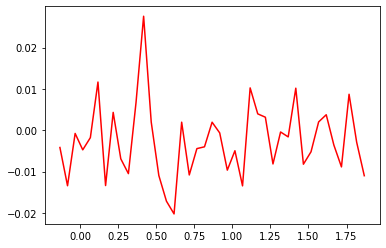

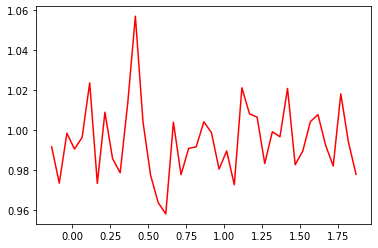

../Data/20201128/expid_TEY-foil-298.4eV-40%-dscan283/283.csv
Data Frame was saved as ../Data/20201128/expid_TEY-foil-298.4eV-40%-dscan283/../283.csv


In [ ]:
#Test
PALdataset_to_CSV('TEY-foil-298.4eV-40%%-dscan283')

In [ ]:
##SHIFT1 20201126 Energy Scan
##SHIFT2 20201127 Energy Scan
##SHIFT3 20201128 Energy Scan
#These are not modulation scan
PALdataset_to_CSV('TEY-foil-298.5eV-dscan249')
PALdataset_to_CSV('TEY-foil-298.5eV-dscan250')
PALdataset_to_CSV('TEY-foil-298.5eV-dscan251')
PALdataset_to_CSV('TEY-foil-299eV-dscan252')
PALdataset_to_CSV('TEY-foil-309eV-dscan253')
PALdataset_to_CSV('TEY-foil-291eV-dscan254')
PALdataset_to_CSV('TEY-foil-298.5eV-dscan255')
PALdataset_to_CSV('TEY-foil-298eV-dscan256')
PALdataset_to_CSV('TEY-foil-297.5eV-dscan257')
PALdataset_to_CSV('TEY-foil-297eV-dscan258')
PALdataset_to_CSV('TEY-foil-296.5eV-dscan259')
PALdataset_to_CSV('TEY-foil-296eV-dscan260')
PALdataset_to_CSV('TEY-foil-295.5eV-dscan261')
PALdataset_to_CSV('TEY-foil-298.5eV-dscan262')
PALdataset_to_CSV('TEY-foil-299.5eV-dscan263')
PALdataset_to_CSV('TEY-foil-300eV-dscan264')
PALdataset_to_CSV('TEY-foil-301eV-dscan265')
PALdataset_to_CSV('TEY-foil-300.5eV-dscan266')
PALdataset_to_CSV('TEY-foil-298.5eV-65%%-dscan267')
PALdataset_to_CSV('TEY-foil-298.5eV-60%%-dscan268')
PALdataset_to_CSV('TEY-foil-298.5eV-55%%-dscan269')
PALdataset_to_CSV('TEY-foil-298.5eV-50%%-dscan270')
PALdataset_to_CSV('TEY-foil-298.5eV-45%%-dscan271')
PALdataset_to_CSV('TEY-foil-298.5eV-40%%-dscan272')
PALdataset_to_CSV('TEY-foil-298.5eV-35%%-dscan273')
PALdataset_to_CSV('TEY-foil-298.5eV-30%%-dscan274')
PALdataset_to_CSV('TEY-foil-298.5eV-30%%-dscan275')
PALdataset_to_CSV('TEY-foil-298.5eV-25%%-dscan276')
PALdataset_to_CSV('TEY-foil-298.5eV-20%%-dscan277')
PALdataset_to_CSV('TEY-foil-296eV-40%%-dscan278')

#PALdataset_to_CSV('TEY-foil-0ps-40%%-escan279')
# 3point delay scan
PALdataset_to_CSV('TEY-foil-0ps-40%%-escan280')
PALdataset_to_CSV('TEY-foil-0.3ps-40%%-escan281')
PALdataset_to_CSV('TEY-foil-1.2ps-40%%-escan282')
PALdataset_to_CSV('TEY-foil-298.4eV-40%%-dscan283')
PALdataset_to_CSV('TEY-foil-296.4eV-40%%-dscan284')
PALdataset_to_CSV('TEY-foil-299.8eV-40%%-dscan285')
PALdataset_to_CSV('TEY-foil-298.4eV-65%%-dscan286')
PALdataset_to_CSV('TEY-foil-0ps-65%%-escan287')
PALdataset_to_CSV('TEY-foil-0.3ps-65%%-escan288')
PALdataset_to_CSV('TEY-foil-1.2ps-65%%-escan289')
PALdataset_to_CSV('TEY-foil-1.2ps-65%%-escan290')
PALdataset_to_CSV('TEY-foil-296.4eV-65%%-dscan291')
PALdataset_to_CSV('TEY-foil-298.4eV-65%%-dscan292')
PALdataset_to_CSV('TEY-foil-299.4eV-65%%-dscan293')
PALdataset_to_CSV('TEY-foil-299.8eV-65%%-dscan294')
PALdataset_to_CSV('TEY-foil-299.4eV-40%%-dscan295')
# test
PALdataset_to_CSV('TEY-single-test-dscan296')
PALdataset_to_CSV('TEY-single-298.4eV-40%%-dscan297')
PALdataset_to_CSV('TEY-single-0ps-65%%-escan298')
PALdataset_to_CSV('TEY-single-274eV-65%%-dscan299')
PALdataset_to_CSV('TEY-single-274eV-40%%-dscan300')
PALdataset_to_CSV('TEY-single-nolaser-escan301')
PALdataset_to_CSV('TEY-single-nolaser-escan302')

##SHIFT4 20201129 Energy Scan
PALdataset_to_CSV('TEY-argon-escan303')
PALdataset_to_CSV('TEY-argon-escan304')
PALdataset_to_CSV('TEY-argon-escan305')
PALdataset_to_CSV('TEY-foil-escan306')
PALdataset_to_CSV('TEY-foil-escan307')
PALdataset_to_CSV('TEY-foil-escan308')
PALdataset_to_CSV('TEY-foil-escan309')
PALdataset_to_CSV('expid_TEY-foil-298.4eV-65%%-dscan310')
PALdataset_to_CSV('expid_TEY-foil-298.4eV-65%%-dscan311')
PALdataset_to_CSV('expid_TEY-foil-298.4eV-65%%-dscan312')
PALdataset_to_CSV('expid_TEY-foil-298.4eV-65%%-dscan313')
PALdataset_to_CSV('TEY-foil--1ps-65%%-escan314')
PALdataset_to_CSV('TEY-foil--50ps-65%%-escan315')
PALdataset_to_CSV('TEY-foil-0.03ps-65%%-escan316')
PALdataset_to_CSV('TEY-foil-0.03ps-65%%-escan317')
PALdataset_to_CSV('expid_TEY-foil-298.4eV-65%%-dscan318')
PALdataset_to_CSV('expid_TEY-foil-298.4eV-40%%-dscan319')
PALdataset_to_CSV('expid_TEY-foil-298.4eV-65%%-dscan320')
PALdataset_to_CSV('TEY-foil-0ps-65%%-escan321')
PALdataset_to_CSV('TEY-foil-0.3ps-65%%-escan322')
PALdataset_to_CSV('TEY-foil-1.2ps-65%%-escan323')
PALdataset_to_CSV('TEY-foil--1.2ps-65%%-escan324')
PALdataset_to_CSV('TEY-foil-3ps-65%%-escan325')
PALdataset_to_CSV('TEY-foil-0.7ps-65%%-escan326')
PALdataset_to_CSV('TEY-foil-0.15ps-65%%-escan327')
PALdataset_to_CSV('TEY-foil-6ps-65%%-escan328')
PALdataset_to_CSV('TEY-foil--0.7ps-65%%-escan329')
PALdataset_to_CSV('TEY-foil-6ps-65%%-escan330')
PALdataset_to_CSV('TEY-foil-12ps-65%%-escan331')
PALdataset_to_CSV('TEY-foil-24ps-65%%-escan332')
PALdataset_to_CSV('TEY-foil-299.3eV-65%-dscan333')
PALdataset_to_CSV('TEY-foil-1000ps-65%%-escan334')
PALdataset_to_CSV('TEY-foil-284.4eV-65%%-dscan335')

##SHIFT5  20201130 Energy Scan hBN
PALdataset_to_CSV('TEY-hbn-escan336')
PALdataset_to_CSV('TEY-hbn-298.4eV-65%%-dscan337')
PALdataset_to_CSV('TEY-hbn-0ps-65%%-escan338')
PALdataset_to_CSV('TEY-hbn-0ps-65%%-escan339')
PALdataset_to_CSV('TEY-hbn-0.15ps-65%%-escan340')
PALdataset_to_CSV('TEY-hbn-0.3ps-65%%-escan341')
PALdataset_to_CSV('TEY-hbn-0.7ps-65%%-escan342')
PALdataset_to_CSV('TEY-hbn-1.2ps-65%%-escan343')
PALdataset_to_CSV('TEY-hbn-3ps-65%%-escan344')
PALdataset_to_CSV('TEY-hbn--1.2ps-65%%-escan345')
PALdataset_to_CSV('TEY-hbn-0ps-65%%-escan346')
PALdataset_to_CSV('TEY-hbn-298.4eV-65%%-dscan347')
PALdataset_to_CSV('TEY-hbn-299.3eV-65%%-dscan348')
PALdataset_to_CSV('TEY-hbn-299.8eV-65%%-dscan349')
PALdataset_to_CSV('TEY-hbn-296.4eV-65%%-dscan350')
#expid_TEY-hbn-65%-2dscan351
#expid_TEY-hbn-60%-2dscan352
#expid_TEY-hbn-55%-2dscan353
#expid_TEY-hbn-50%-2dscan354
#expid_TEY-hbn-45%-2dscan35
#expid_TEY-hbn-40%-2dscan356
#expid_TEY-hbn-35%-2dscan357
#expid_TEY-hbn-30%-2dscan358
#expid_TEY-hbn-25%-2dscan359
# delay scan foil
PALdataset_to_CSV('TEY-foil-298.4eV-65%%-dscan360')
PALdataset_to_CSV('TEY-foil-0ps-65%%-escan361')
PALdataset_to_CSV('TEY-foil-295.5eV-65%%-dscan362')
PALdataset_to_CSV('TEY-foil-295.75eV-65%%-dscan363')
PALdataset_to_CSV('TEY-foil-296eV-65%%-dscan364')
PALdataset_to_CSV('TEY-foil-296.25eV-65%%-dscan365')
PALdataset_to_CSV('TEY-foil-296.5eV-65%%-dscan366')
PALdataset_to_CSV('TEY-foil-296.75eV-65%%-dscan367')
PALdataset_to_CSV('TEY-foil-297eV-65%%-dscan368')
PALdataset_to_CSV('TEY-foil-297.25eV-65%%-dscan369')
PALdataset_to_CSV('TEY-foil-297.5eV-65%%-dscan370')
PALdataset_to_CSV('TEY-foil-297.75eV-65%%-dscan371')
PALdataset_to_CSV('TEY-foil-298eV-65%%-dscan372')
PALdataset_to_CSV('TEY-foil-298.25eV-65%%-dscan373')
PALdataset_to_CSV('TEY-foil-298.5eV-65%%-dscan374')
PALdataset_to_CSV('TEY-foil-298.75eV-65%%-dscan375')
PALdataset_to_CSV('TEY-foil-299eV-65%%-dscan376')
PALdataset_to_CSV('TEY-foil-299.25eV-65%%-dscan377')
PALdataset_to_CSV('TEY-foil-299.5eV-65%%-dscan378')
PALdataset_to_CSV('TEY-foil-300eV-65%%-dscan379')
PALdataset_to_CSV('TEY-foil-300.5eV-65%%-dscan380')
PALdataset_to_CSV('TEY-foil-301eV-65%%-dscan381')
PALdataset_to_CSV('TEY-foil-298.4V-65%%-dscan382')
#expid_TEY-foil-65%-2dscan383
#expid_TEY-foil-60%-2dscan384
#expid_TEY-foil-55%-2dscan385
#expid_TEY-foil-50%-2dscan386
#expid_TEY-foil-45%-2dscan387
#expid_TEY-foil-40%-2dscan388
#expid_TEY-foil-35%-2dscan389
#expid_TEY-foil-30%-2dscan390
#expid_TEY-foil-25%-2dscan391
#expid_TEY-foil-299.3eV-65%-dscan392
#expid_TEY-foil-299.8eV-65%-dscan393
#expid_TEY-foil-296.4eV-65%-dscan394

##SHIFT6  20201201 Energy Scan
#s-pol
PALdataset_to_CSV('TEY-hbn-295.5eV-65%%-dscan397')
PALdataset_to_CSV('TEY-hbn--1ps-65%%-escan398')
PALdataset_to_CSV('TEY-hbn-295.75eV-65%%-dscan399')
PALdataset_to_CSV('TEY-hbn-296eV-65%%-dscan400')
PALdataset_to_CSV('TEY-hbn-296.25eV-65%%-dscan401')
PALdataset_to_CSV('TEY-hbn-296.5eV-65%%-dscan402')
PALdataset_to_CSV('TEY-hbn-296.75eV-65%%-dscan403')
PALdataset_to_CSV('TEY-hbn-297eV-65%%-dscan404')
PALdataset_to_CSV('TEY-hbn-297.25eV-65%%-dscan405')
PALdataset_to_CSV('TEY-hbn-297.50eV-65%%-dscan406')
PALdataset_to_CSV('TEY-hbn-297.75eV-65%%-dscan407')
PALdataset_to_CSV('TEY-hbn-298eV-65%%-dscan408')
PALdataset_to_CSV('TEY-hbn-298.25eV-65%%-dscan409')
PALdataset_to_CSV('TEY-hbn-298.50eV-65%%-dscan410')
PALdataset_to_CSV('TEY-hbn-298.75eV-65%%-dscan411')
PALdataset_to_CSV('TEY-hbn-299eV-65%%-dscan412')
PALdataset_to_CSV('TEY-hbn-nolaser-escan413')
PALdataset_to_CSV('TEY-hbn-299.25eV-65%%-dscan414')
PALdataset_to_CSV('TEY-hbn-299.50eV-65%%-dscan415')
PALdataset_to_CSV('TEY-hbn-299.75eV-65%%-dscan416')
PALdataset_to_CSV('TEY-hbn-300eV-65%%-dscan417')
PALdataset_to_CSV('TEY-hbn-300.5eV-65%%-dscan418')
PALdataset_to_CSV('TEY-hbn-301eV-65%%-dscan419')
PALdataset_to_CSV('TEY-hbn-299.25eV-65%%-dscan420')
PALdataset_to_CSV('TEY-hbn-6ps-65%%-escan421')
PALdataset_to_CSV('TEY-hbn-130ps-65%%-escan422')
PALdataset_to_CSV('TEY-hbn-1500ps-65%%-escan423')
PALdataset_to_CSV('TEY-hbn--0.4ps-65%%-escan424')
PALdataset_to_CSV('TEY-hbn--0.2ps-65%%-escan425')
PALdataset_to_CSV('TEY-hbn-0ps-65%%-escan426')
PALdataset_to_CSV('TEY-hbn-0.2ps-65%%-escan427')
PALdataset_to_CSV('TEY-hbn-298.4eV-65%%-dscan428')
PALdataset_to_CSV('TEY-hbn--0.6ps-65%%-escan429')
PALdataset_to_CSV('TEY-hbn-0.4ps-65%%-escan430')
PALdataset_to_CSV('TEY-hbn--0.2ps-65%%-escan431')
PALdataset_to_CSV('TEY-hbn-1ps-65%%-escan432')
PALdataset_to_CSV('TEY-hbn--0.4ps-65%%-escan433')
PALdataset_to_CSV('TEY-hbn-298.4eV-65%-dscan434')
PALdataset_to_CSV('TEY-hbn--1ps-65%%-escan435')
PALdataset_to_CSV('TEY-hbn-1ps-65%%-escan436')
#p-pol
PALdataset_to_CSV('TEY-hbn-298.4eV-65%%-dscan437')
PALdataset_to_CSV('TEY-hbn-299.25eV-65%%-dscan438')
PALdataset_to_CSV('TEY-hbn-296.25eV-65%%-dscan439')
PALdataset_to_CSV('TEY-hbn-300eV-65%%-dscan440')
PALdataset_to_CSV('TEY-hbn--0.27ps-65%%-escan441')
PALdataset_to_CSV('TEY-hbn-3ps-65%%-escan442')

TEY-foil-298.5eV-dscan249 will be processed.


NoSectionError: No section: 'TEY-foil-298.5eV-dscan249'

In [ ]:
### delay scan foil
PALdataset_to_CSV('TEY-foil-298.4eV-65%%-dscan360')
PALdataset_to_CSV('TEY-foil-0ps-65%%-escan361')
PALdataset_to_CSV('TEY-foil-295.5eV-65%%-dscan362')
PALdataset_to_CSV('TEY-foil-295.75eV-65%%-dscan363')
PALdataset_to_CSV('TEY-foil-296eV-65%%-dscan364')
PALdataset_to_CSV('TEY-foil-296.25eV-65%%-dscan365')
PALdataset_to_CSV('TEY-foil-296.5eV-65%%-dscan366')
PALdataset_to_CSV('TEY-foil-296.75eV-65%%-dscan367')
PALdataset_to_CSV('TEY-foil-297eV-65%%-dscan368')
PALdataset_to_CSV('TEY-foil-297.25eV-65%%-dscan369')
PALdataset_to_CSV('TEY-foil-297.5eV-65%%-dscan370')
PALdataset_to_CSV('TEY-foil-297.75eV-65%%-dscan371')
PALdataset_to_CSV('TEY-foil-298eV-65%%-dscan372')
PALdataset_to_CSV('TEY-foil-298.25eV-65%%-dscan373')
PALdataset_to_CSV('TEY-foil-298.5eV-65%%-dscan374')
#PALdataset_to_CSV('TEY-foil-298.75eV-65%%-dscan375')
PALdataset_to_CSV('TEY-foil-299eV-65%%-dscan376')
PALdataset_to_CSV('TEY-foil-299.25eV-65%%-dscan377')
PALdataset_to_CSV('TEY-foil-299.5eV-65%%-dscan378')
PALdataset_to_CSV('TEY-foil-300eV-65%%-dscan379')
PALdataset_to_CSV('TEY-foil-300.5eV-65%%-dscan380')
PALdataset_to_CSV('TEY-foil-301eV-65%%-dscan381')
PALdataset_to_CSV('TEY-foil-298.4V-65%%-dscan382')


TEY-foil-298.4eV-65%%-dscan360 will be processed.
Files in ../Data/20201130/expid_TEY-foil-298.4eV-65%-dscan360 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-298.4eV-65%-dscan360/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298.4'] 36600 / 36600 matched.


TEY-hbn-escan336 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-escan336 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-escan336/*MCP*.*
Number of Shots/File: 300
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.65 15300 / 15300 matched.
RepeatNumber == 0.0 15300 / 15300 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 7650 / 15300 matched.
LaserOFF (TimestampAbsSec%12 ==0) 7650 / 15300 matched.


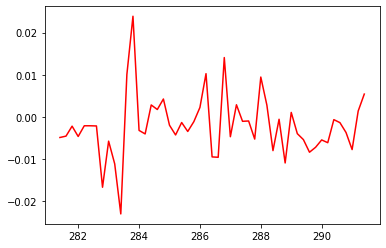

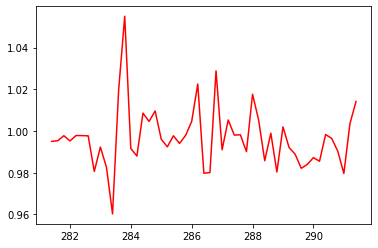

../Data/20201130/expid_TEY-hbn-escan336/336.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-escan336/../336.csv
TEY-hbn-298.4eV-65%%-dscan337 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-298.4eV-65%-dscan337 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-298.4eV-65%-dscan337/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298.4'] 41400 / 41400 matched.
RepeatNumber == 0.0 41400 / 41400 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 20700 / 41400 matched.
LaserOFF (TimestampAbsSec%12 ==0) 20700 / 41400 matched.
DelayOfInterest [-41.57   -41.5625 -41.555  -41.5475 -41.54   -41.5325 -41.525  -41.5175
 -41.51   -41.5025 -41.495  -41.4875 -41.48   -41.4725 -41.465  -41.4575
 -41.45   -41.4425 -41

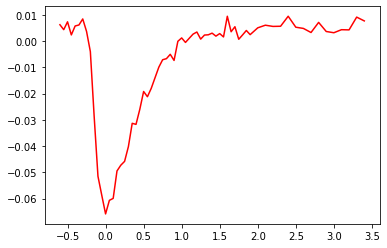

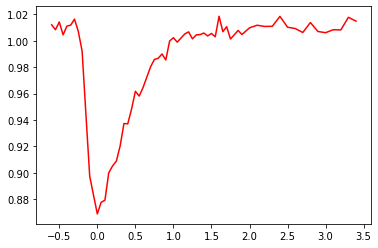

../Data/20201130/expid_TEY-hbn-298.4eV-65%-dscan337/337.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-298.4eV-65%-dscan337/../337.csv
TEY-hbn-0ps-65%%-escan338 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-0ps-65%-escan338 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-0ps-65%-escan338/*MCP*.*
Number of Shots/File: 300
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.4875 24300 / 24300 matched.
RepeatNumber == 0.0 24300 / 24300 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 12150 / 24300 matched.
LaserOFF (TimestampAbsSec%12 ==0) 12150 / 24300 matched.


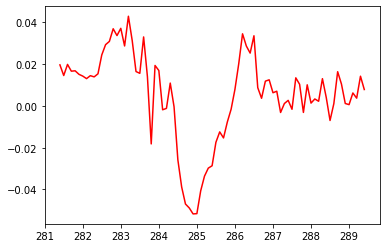

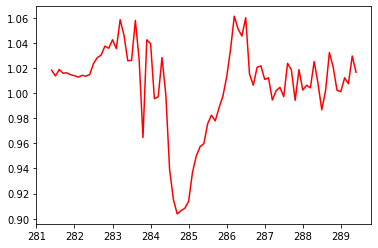

../Data/20201130/expid_TEY-hbn-0ps-65%-escan338/338.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-0ps-65%-escan338/../338.csv
TEY-hbn-0ps-65%%-escan339 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-0ps-65%-escan339 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-0ps-65%-escan339/*MCP*.*
Number of Shots/File: 300
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.4875 24300 / 24300 matched.
RepeatNumber == 0.0 24300 / 24300 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 12150 / 24300 matched.
LaserOFF (TimestampAbsSec%12 ==0) 12150 / 24300 matched.


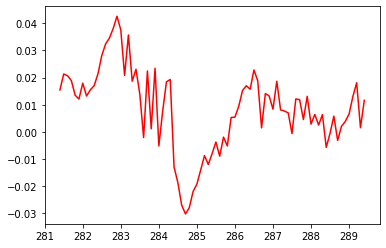

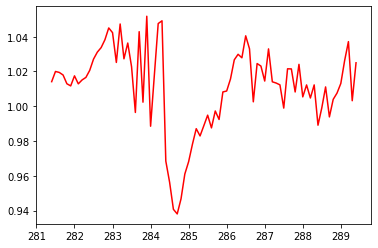

../Data/20201130/expid_TEY-hbn-0ps-65%-escan339/339.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-0ps-65%-escan339/../339.csv
TEY-hbn-0.15ps-65%%-escan340 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-0.15ps-65%-escan340 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-0.15ps-65%-escan340/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.465 48600 / 48600 matched.
RepeatNumber == 0.0 48600 / 48600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 24300 / 48600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 24300 / 48600 matched.


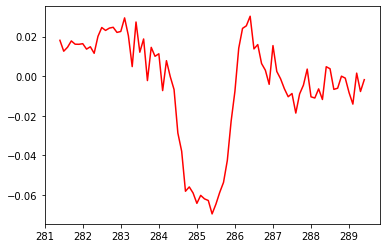

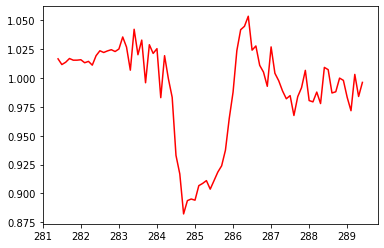

../Data/20201130/expid_TEY-hbn-0.15ps-65%-escan340/340.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-0.15ps-65%-escan340/../340.csv
TEY-hbn-0.3ps-65%%-escan341 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-0.3ps-65%-escan341 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-0.3ps-65%-escan341/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.4425 48600 / 48600 matched.
RepeatNumber == 0.0 48600 / 48600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 24300 / 48600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 24300 / 48600 matched.


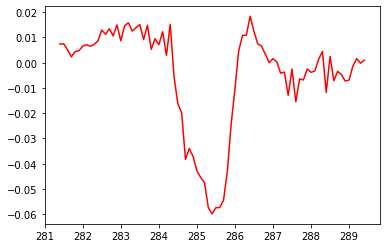

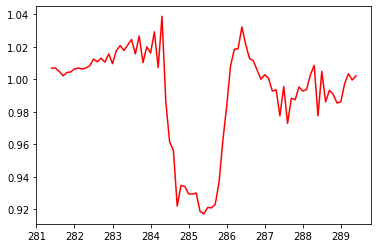

../Data/20201130/expid_TEY-hbn-0.3ps-65%-escan341/341.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-0.3ps-65%-escan341/../341.csv
TEY-hbn-0.7ps-65%%-escan342 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-0.7ps-65%-escan342 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-0.7ps-65%-escan342/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.3826 48600 / 48600 matched.
RepeatNumber == 0.0 48600 / 48600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 24300 / 48600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 24300 / 48600 matched.


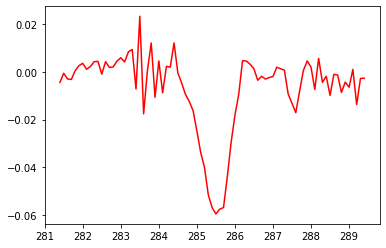

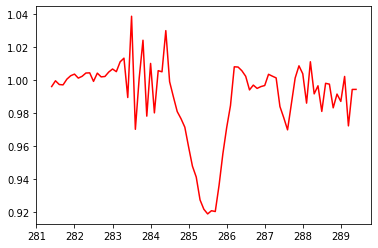

../Data/20201130/expid_TEY-hbn-0.7ps-65%-escan342/342.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-0.7ps-65%-escan342/../342.csv
TEY-hbn-1.2ps-65%%-escan343 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-1.2ps-65%-escan343 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-1.2ps-65%-escan343/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.3077 48600 / 48600 matched.
RepeatNumber == 0.0 48600 / 48600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 24300 / 48600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 24300 / 48600 matched.


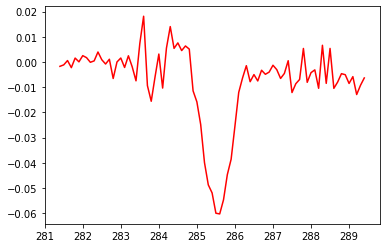

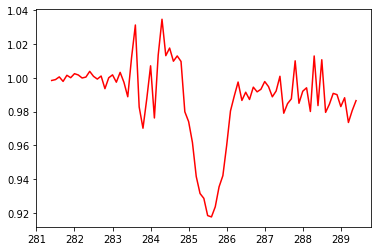

../Data/20201130/expid_TEY-hbn-1.2ps-65%-escan343/343.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-1.2ps-65%-escan343/../343.csv
TEY-hbn-3ps-65%%-escan344 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-3ps-65%-escan344 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-3ps-65%-escan344/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.038 48600 / 48600 matched.
RepeatNumber == 0.0 48600 / 48600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 24300 / 48600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 24300 / 48600 matched.


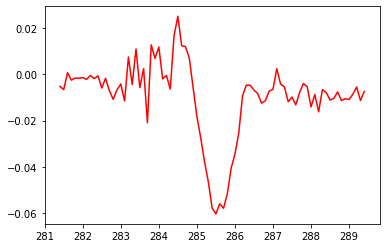

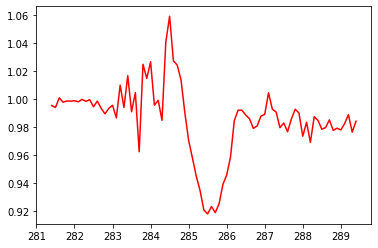

../Data/20201130/expid_TEY-hbn-3ps-65%-escan344/344.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-3ps-65%-escan344/../344.csv
TEY-hbn--1.2ps-65%%-escan345 will be processed.
Files in ../Data/20201130/expid_TEY-hbn--1.2ps-65%-escan345 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn--1.2ps-65%-escan345/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.6673 48600 / 48600 matched.
RepeatNumber == 0.0 48600 / 48600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 24300 / 48600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 24300 / 48600 matched.


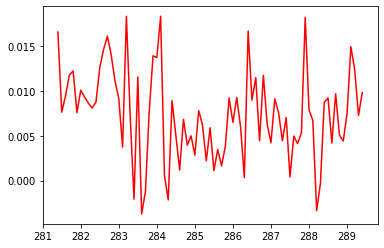

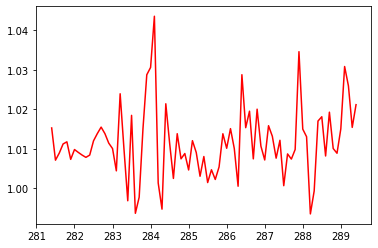

../Data/20201130/expid_TEY-hbn--1.2ps-65%-escan345/345.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn--1.2ps-65%-escan345/../345.csv
TEY-hbn-298.4eV-65%%-dscan347 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-298.4eV-65%-dscan347 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-298.4eV-65%-dscan347/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298.4'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -41.4875


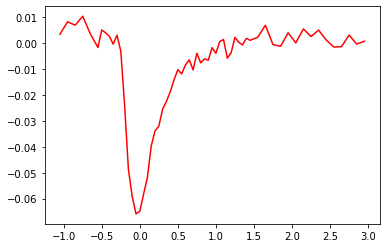

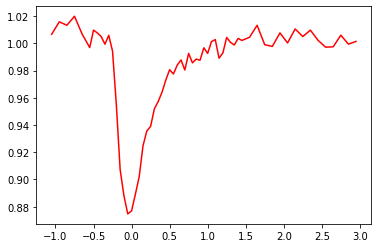

../Data/20201130/expid_TEY-hbn-298.4eV-65%-dscan347/347.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-298.4eV-65%-dscan347/../347.csv
TEY-hbn-299.3eV-65%%-dscan348 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-299.3eV-65%-dscan348 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-299.3eV-65%-dscan348/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['299.3'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -41.487

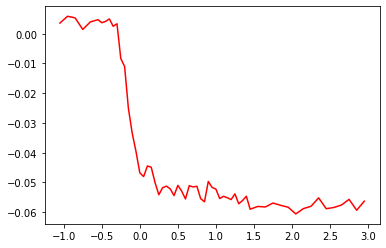

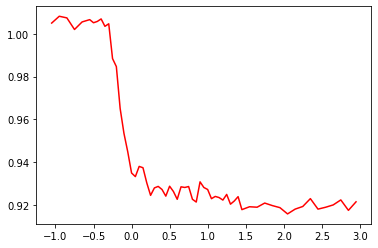

../Data/20201130/expid_TEY-hbn-299.3eV-65%-dscan348/348.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-299.3eV-65%-dscan348/../348.csv
TEY-hbn-299.8eV-65%%-dscan349 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-299.8eV-65%-dscan349 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-299.8eV-65%-dscan349/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['299.8'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -41.487

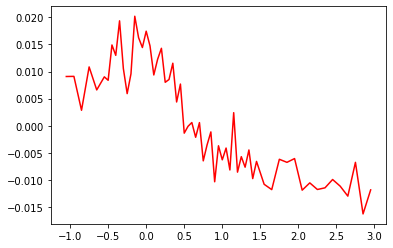

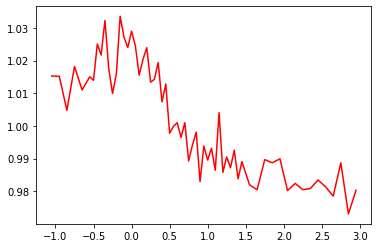

../Data/20201130/expid_TEY-hbn-299.8eV-65%-dscan349/349.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-299.8eV-65%-dscan349/../349.csv
TEY-hbn-296.4eV-65%%-dscan350 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-296.4eV-65%-dscan350 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-296.4eV-65%-dscan350/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['296.4'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -41.487

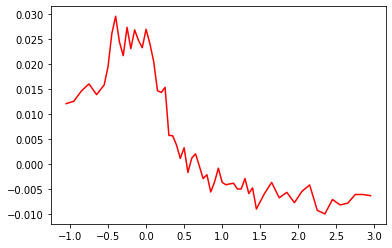

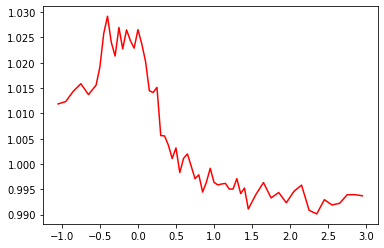

../Data/20201130/expid_TEY-hbn-296.4eV-65%-dscan350/350.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-296.4eV-65%-dscan350/../350.csv
TEY-foil-0ps-65%%-escan361 will be processed.
Files in ../Data/20201130/expid_TEY-foil-0ps-65%-escan361 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-0ps-65%-escan361/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.51 48600 / 48600 matched.
RepeatNumber == 0.0 48600 / 48600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 24300 / 48600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 24300 / 48600 matched.


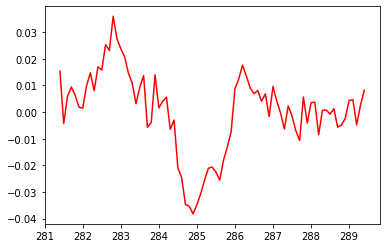

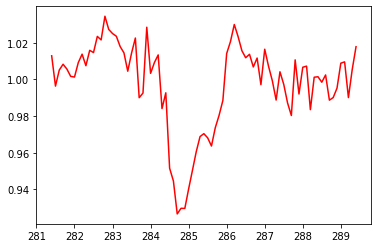

../Data/20201130/expid_TEY-foil-0ps-65%-escan361/361.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-0ps-65%-escan361/../361.csv
TEY-foil-295.5eV-65%%-dscan362 will be processed.
Files in ../Data/20201130/expid_TEY-foil-295.5eV-65%-dscan362 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-295.5eV-65%-dscan362/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['295.5'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -41.4875
 

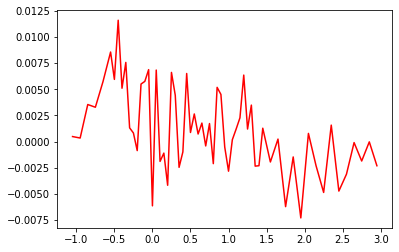

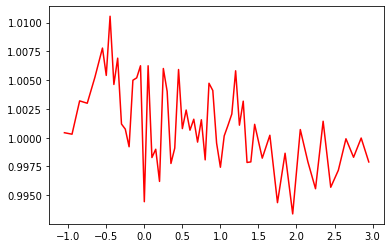

../Data/20201130/expid_TEY-foil-295.5eV-65%-dscan362/362.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-295.5eV-65%-dscan362/../362.csv
TEY-foil-295.75eV-65%%-dscan363 will be processed.
Files in ../Data/20201130/expid_TEY-foil-295.75eV-65%-dscan363 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-295.75eV-65%-dscan363/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['295.75'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495

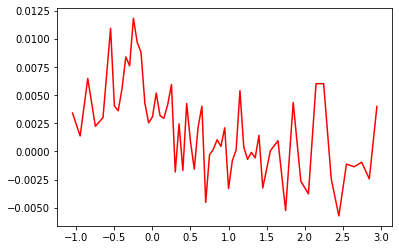

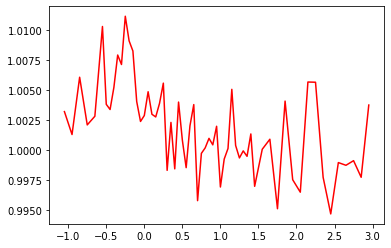

../Data/20201130/expid_TEY-foil-295.75eV-65%-dscan363/363.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-295.75eV-65%-dscan363/../363.csv
TEY-foil-296eV-65%%-dscan364 will be processed.
Files in ../Data/20201130/expid_TEY-foil-296eV-65%-dscan364 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-296eV-65%-dscan364/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['296'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -41.4875

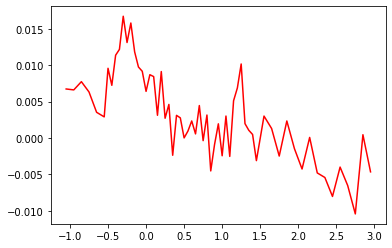

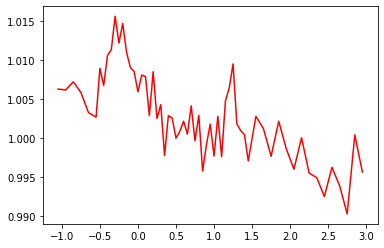

../Data/20201130/expid_TEY-foil-296eV-65%-dscan364/364.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-296eV-65%-dscan364/../364.csv
TEY-foil-296.25eV-65%%-dscan365 will be processed.
Files in ../Data/20201130/expid_TEY-foil-296.25eV-65%-dscan365 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-296.25eV-65%-dscan365/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['296.25'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -4

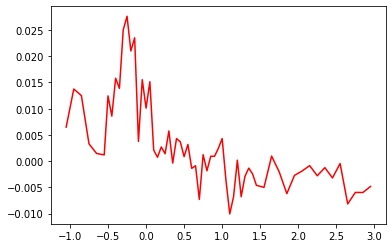

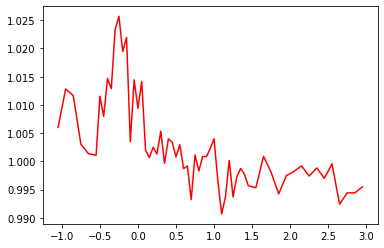

../Data/20201130/expid_TEY-foil-296.25eV-65%-dscan365/365.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-296.25eV-65%-dscan365/../365.csv
TEY-foil-296.5eV-65%%-dscan366 will be processed.
Files in ../Data/20201130/expid_TEY-foil-296.5eV-65%-dscan366 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-296.5eV-65%-dscan366/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['296.5'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  

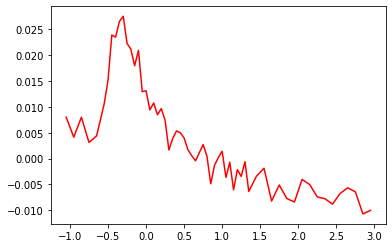

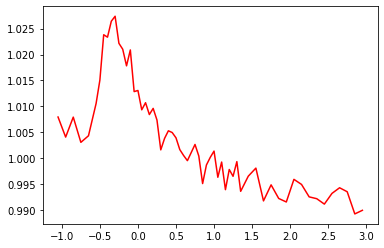

../Data/20201130/expid_TEY-foil-296.5eV-65%-dscan366/366.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-296.5eV-65%-dscan366/../366.csv
TEY-foil-296.75eV-65%%-dscan367 will be processed.
Files in ../Data/20201130/expid_TEY-foil-296.75eV-65%-dscan367 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-296.75eV-65%-dscan367/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['296.75'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495

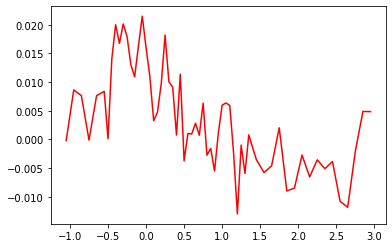

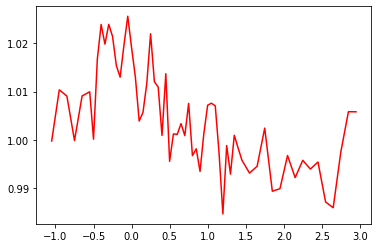

../Data/20201130/expid_TEY-foil-296.75eV-65%-dscan367/367.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-296.75eV-65%-dscan367/../367.csv
TEY-foil-297eV-65%%-dscan368 will be processed.
Files in ../Data/20201130/expid_TEY-foil-297eV-65%-dscan368 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-297eV-65%-dscan368/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['297'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -41.4875

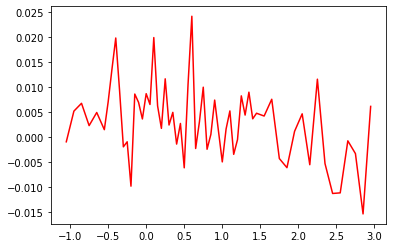

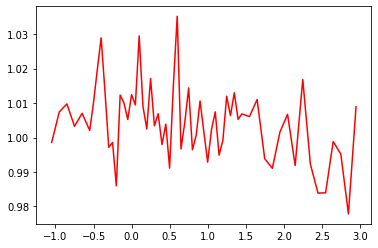

../Data/20201130/expid_TEY-foil-297eV-65%-dscan368/368.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-297eV-65%-dscan368/../368.csv
TEY-foil-297.25eV-65%%-dscan369 will be processed.
Files in ../Data/20201130/expid_TEY-foil-297.25eV-65%-dscan369 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-297.25eV-65%-dscan369/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['297.25'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -4

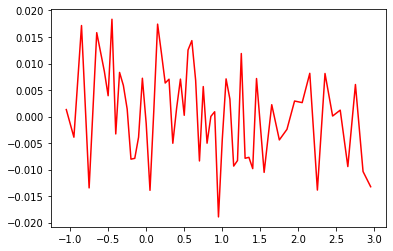

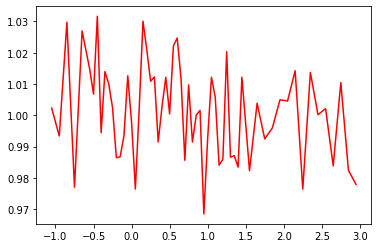

../Data/20201130/expid_TEY-foil-297.25eV-65%-dscan369/369.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-297.25eV-65%-dscan369/../369.csv
TEY-foil-297.5eV-65%%-dscan370 will be processed.
Files in ../Data/20201130/expid_TEY-foil-297.5eV-65%-dscan370 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-297.5eV-65%-dscan370/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['297.5'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  

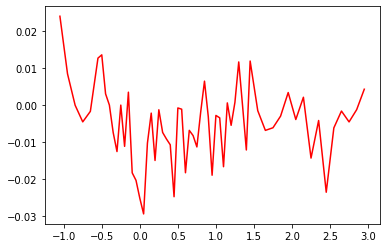

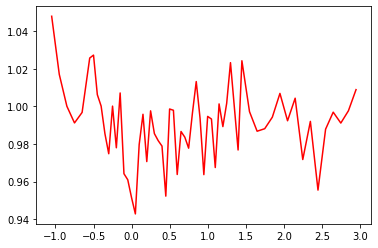

../Data/20201130/expid_TEY-foil-297.5eV-65%-dscan370/370.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-297.5eV-65%-dscan370/../370.csv
TEY-foil-297.75eV-65%%-dscan371 will be processed.
Files in ../Data/20201130/expid_TEY-foil-297.75eV-65%-dscan371 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-297.75eV-65%-dscan371/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['297.75'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495

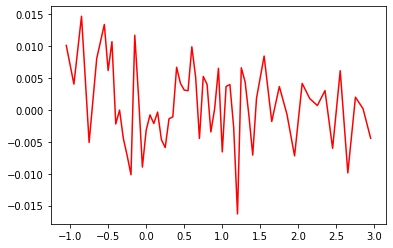

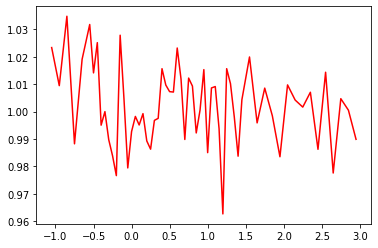

../Data/20201130/expid_TEY-foil-297.75eV-65%-dscan371/371.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-297.75eV-65%-dscan371/../371.csv
TEY-foil-298eV-65%%-dscan372 will be processed.
Files in ../Data/20201130/expid_TEY-foil-298eV-65%-dscan372 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-298eV-65%-dscan372/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -41.4875

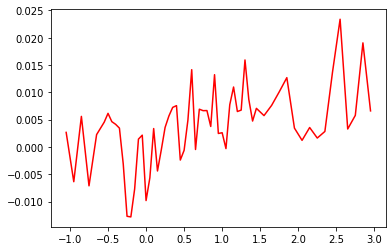

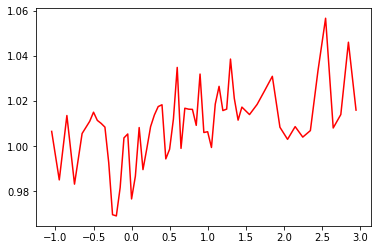

../Data/20201130/expid_TEY-foil-298eV-65%-dscan372/372.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-298eV-65%-dscan372/../372.csv
TEY-foil-298.25eV-65%%-dscan373 will be processed.
Files in ../Data/20201130/expid_TEY-foil-298.25eV-65%-dscan373 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-298.25eV-65%-dscan373/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298.25'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -4

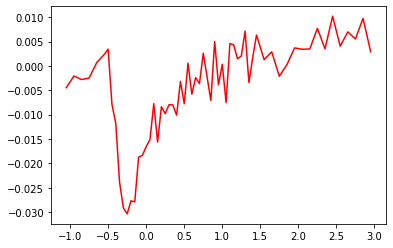

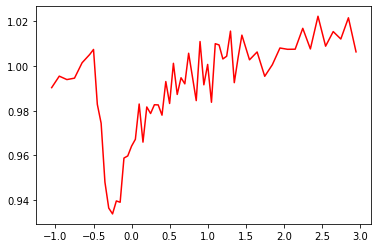

../Data/20201130/expid_TEY-foil-298.25eV-65%-dscan373/373.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-298.25eV-65%-dscan373/../373.csv
TEY-foil-298.5eV-65%%-dscan374 will be processed.
Files in ../Data/20201130/expid_TEY-foil-298.5eV-65%-dscan374 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-298.5eV-65%-dscan374/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298.5'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  

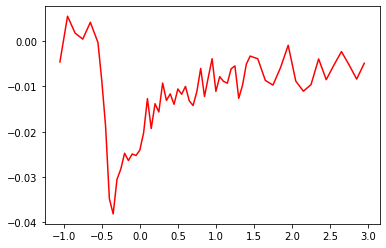

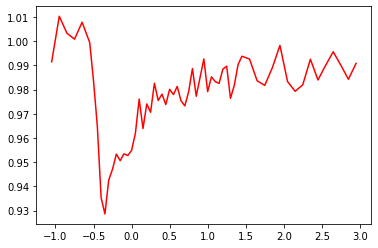

../Data/20201130/expid_TEY-foil-298.5eV-65%-dscan374/374.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-298.5eV-65%-dscan374/../374.csv
TEY-foil-299eV-65%%-dscan376 will be processed.
Files in ../Data/20201130/expid_TEY-foil-299eV-65%-dscan376 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-299eV-65%-dscan376/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['299'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -41.4875
 

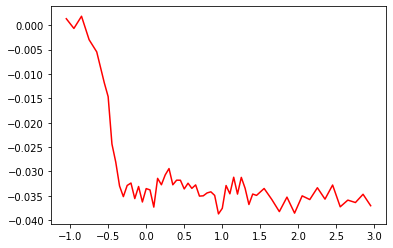

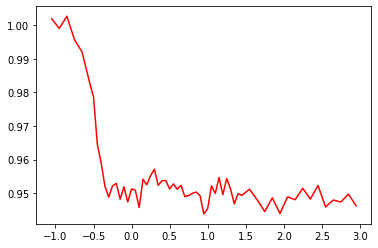

../Data/20201130/expid_TEY-foil-299eV-65%-dscan376/376.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-299eV-65%-dscan376/../376.csv
TEY-foil-299.25eV-65%%-dscan377 will be processed.
Files in ../Data/20201130/expid_TEY-foil-299.25eV-65%-dscan377 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-299.25eV-65%-dscan377/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['299.25'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -4

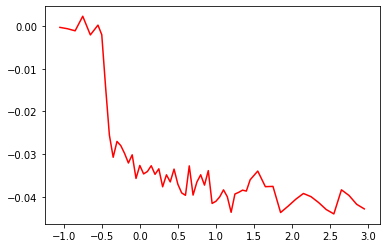

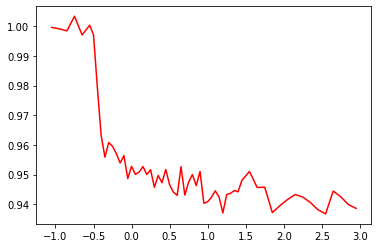

../Data/20201130/expid_TEY-foil-299.25eV-65%-dscan377/377.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-299.25eV-65%-dscan377/../377.csv
TEY-foil-299.5eV-65%%-dscan378 will be processed.
Files in ../Data/20201130/expid_TEY-foil-299.5eV-65%-dscan378 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-299.5eV-65%-dscan378/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['299.5'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  

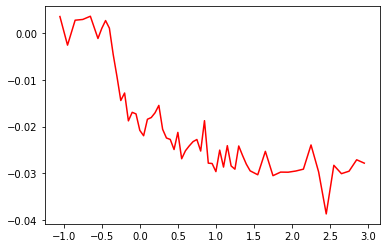

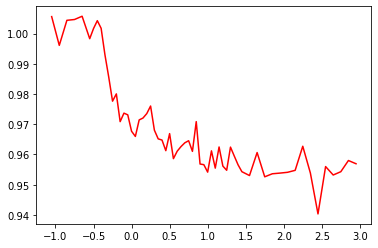

../Data/20201130/expid_TEY-foil-299.5eV-65%-dscan378/378.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-299.5eV-65%-dscan378/../378.csv
TEY-foil-300eV-65%%-dscan379 will be processed.
Files in ../Data/20201130/expid_TEY-foil-300eV-65%-dscan379 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-300eV-65%-dscan379/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['300'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -41.4875
 

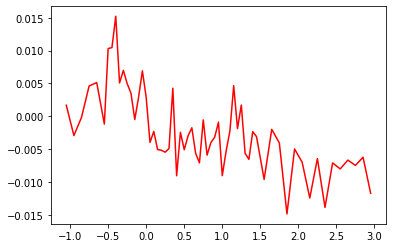

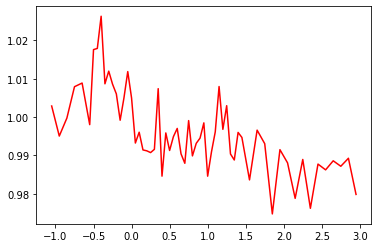

../Data/20201130/expid_TEY-foil-300eV-65%-dscan379/379.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-300eV-65%-dscan379/../379.csv
TEY-foil-300.5eV-65%%-dscan380 will be processed.
Files in ../Data/20201130/expid_TEY-foil-300.5eV-65%-dscan380 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-300.5eV-65%-dscan380/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['300.5'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -41.48

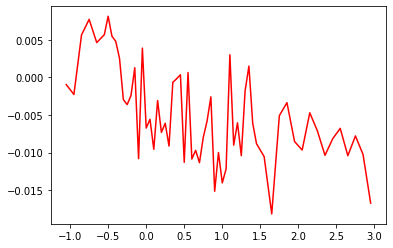

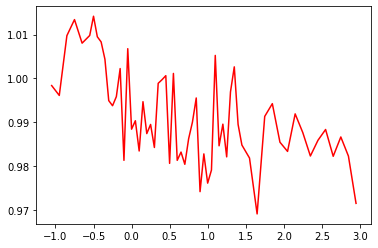

../Data/20201130/expid_TEY-foil-300.5eV-65%-dscan380/380.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-300.5eV-65%-dscan380/../380.csv
TEY-foil-301eV-65%%-dscan381 will be processed.
Files in ../Data/20201130/expid_TEY-foil-301eV-65%-dscan381 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-301eV-65%-dscan381/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['301'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -41.4875
 

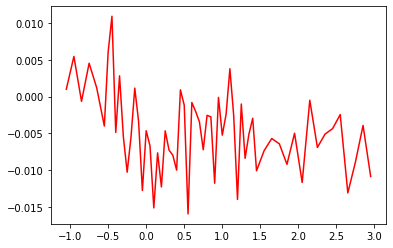

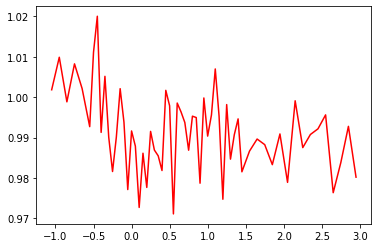

../Data/20201130/expid_TEY-foil-301eV-65%-dscan381/381.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-301eV-65%-dscan381/../381.csv
TEY-foil-298.4V-65%%-dscan382 will be processed.
Files in ../Data/20201130/expid_TEY-foil-298.4V-65%-dscan382 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-foil-298.4V-65%-dscan382/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298.4'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.6375 -41.6225 -41.6075 -41.5925 -41.5775 -41.5625 -41.555  -41.5475
 -41.54   -41.5325 -41.525  -41.5175 -41.51   -41.5025 -41.495  -41.4875


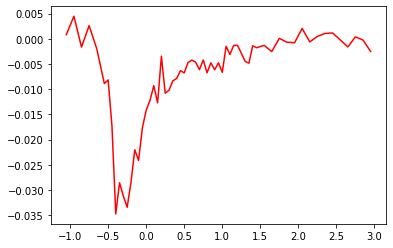

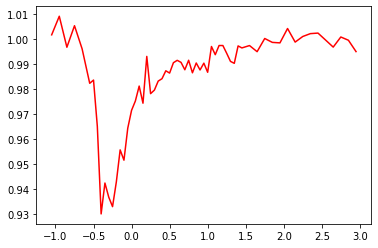

../Data/20201130/expid_TEY-foil-298.4V-65%-dscan382/382.csv
Data Frame was saved as ../Data/20201130/expid_TEY-foil-298.4V-65%-dscan382/../382.csv
TEY-hbn-295.5eV-65%%-dscan397 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-295.5eV-65%-dscan397 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-295.5eV-65%-dscan397/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['295.5'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -

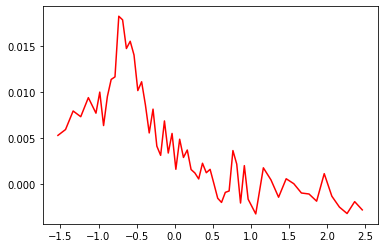

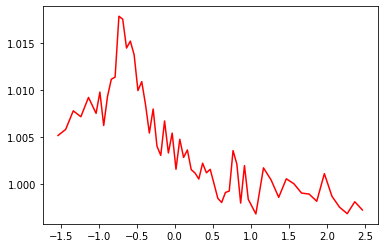

../Data/20201201/expid_TEY-hbn-295.5eV-65%-dscan397/397.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-295.5eV-65%-dscan397/../397.csv
TEY-hbn--1ps-65%%-escan398 will be processed.
Files in ../Data/20201201/expid_TEY-hbn--1ps-65%-escan398 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn--1ps-65%-escan398/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.71 24600 / 24600 matched.
RepeatNumber == 0.0 24600 / 24600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 12300 / 24600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 12300 / 24600 matched.


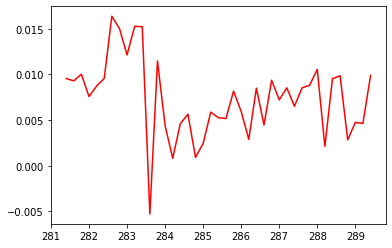

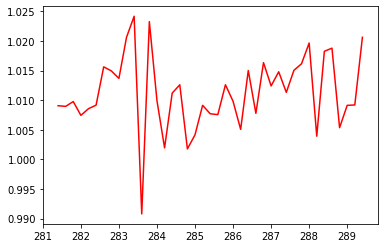

../Data/20201201/expid_TEY-hbn--1ps-65%-escan398/398.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn--1ps-65%-escan398/../398.csv
TEY-hbn-295.75eV-65%%-dscan399 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-295.75eV-65%-dscan399 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-295.75eV-65%-dscan399/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['295.75'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -41

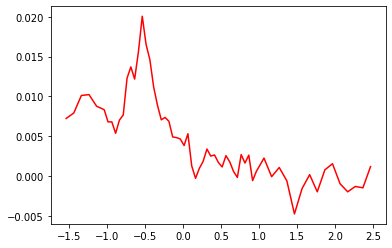

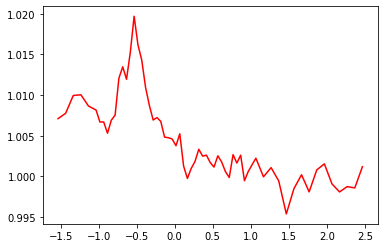

../Data/20201201/expid_TEY-hbn-295.75eV-65%-dscan399/399.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-295.75eV-65%-dscan399/../399.csv
TEY-hbn-296eV-65%%-dscan400 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-296eV-65%-dscan400 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-296eV-65%-dscan400/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['296'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -41.552

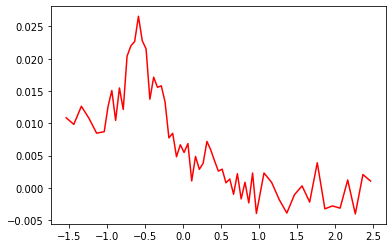

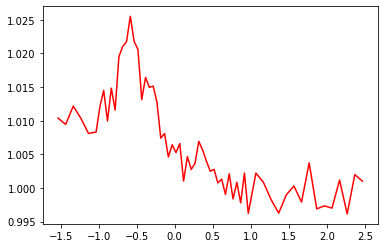

../Data/20201201/expid_TEY-hbn-296eV-65%-dscan400/400.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-296eV-65%-dscan400/../400.csv
TEY-hbn-296.25eV-65%%-dscan401 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-296.25eV-65%-dscan401 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-296.25eV-65%-dscan401/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['296.25'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -

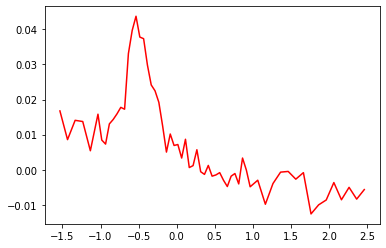

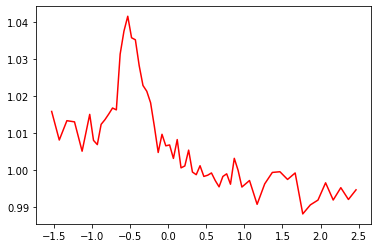

../Data/20201201/expid_TEY-hbn-296.25eV-65%-dscan401/401.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-296.25eV-65%-dscan401/../401.csv
TEY-hbn-296.5eV-65%%-dscan402 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-296.5eV-65%-dscan402 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-296.5eV-65%-dscan402/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['296.5'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56


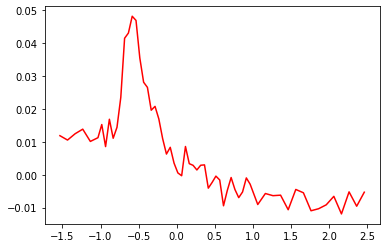

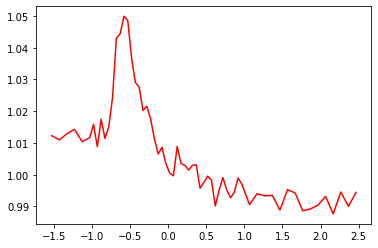

../Data/20201201/expid_TEY-hbn-296.5eV-65%-dscan402/402.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-296.5eV-65%-dscan402/../402.csv
TEY-hbn-296.75eV-65%%-dscan403 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-296.75eV-65%-dscan403 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-296.75eV-65%-dscan403/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['296.75'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.5

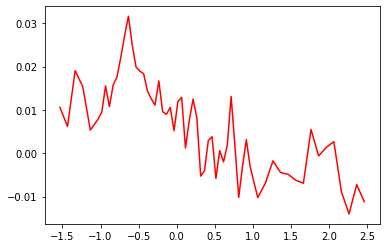

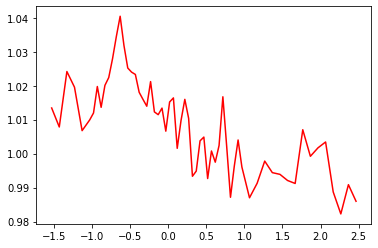

../Data/20201201/expid_TEY-hbn-296.75eV-65%-dscan403/403.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-296.75eV-65%-dscan403/../403.csv
TEY-hbn-297eV-65%%-dscan404 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-297eV-65%-dscan404 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-297eV-65%-dscan404/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['297'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -41.552

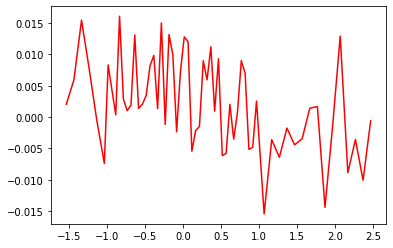

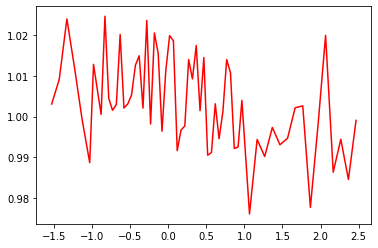

../Data/20201201/expid_TEY-hbn-297eV-65%-dscan404/404.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-297eV-65%-dscan404/../404.csv
TEY-hbn-297.25eV-65%%-dscan405 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-297.25eV-65%-dscan405 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-297.25eV-65%-dscan405/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['297.25'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -

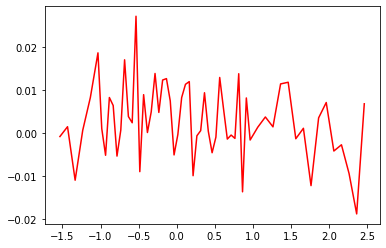

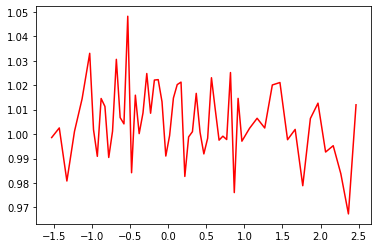

../Data/20201201/expid_TEY-hbn-297.25eV-65%-dscan405/405.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-297.25eV-65%-dscan405/../405.csv
TEY-hbn-297.50eV-65%%-dscan406 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-297.50eV-65%-dscan406 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-297.50eV-65%-dscan406/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['297.50'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41

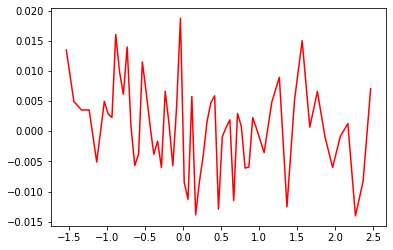

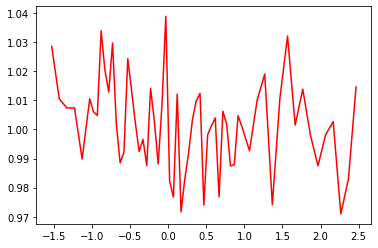

../Data/20201201/expid_TEY-hbn-297.50eV-65%-dscan406/406.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-297.50eV-65%-dscan406/../406.csv
TEY-hbn-297.75eV-65%%-dscan407 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-297.75eV-65%-dscan407 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-297.75eV-65%-dscan407/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['297.75'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41

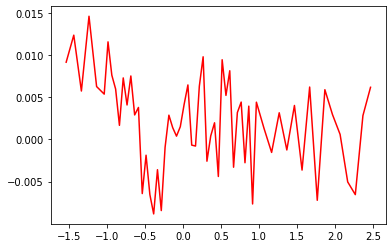

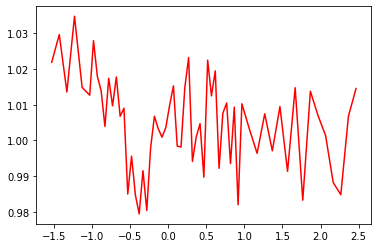

../Data/20201201/expid_TEY-hbn-297.75eV-65%-dscan407/407.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-297.75eV-65%-dscan407/../407.csv
TEY-hbn-298eV-65%%-dscan408 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-298eV-65%-dscan408 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-298eV-65%-dscan408/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -41.552

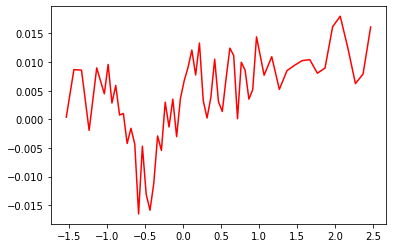

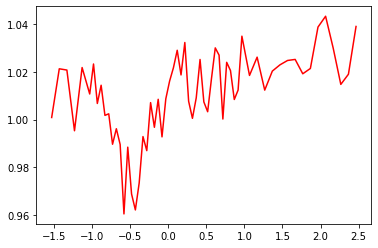

../Data/20201201/expid_TEY-hbn-298eV-65%-dscan408/408.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-298eV-65%-dscan408/../408.csv
TEY-hbn-298.25eV-65%%-dscan409 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-298.25eV-65%-dscan409 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-298.25eV-65%-dscan409/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298.25'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -

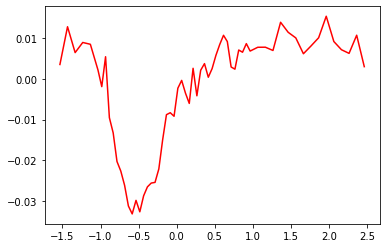

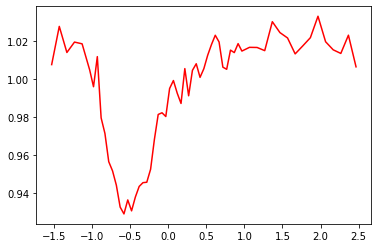

../Data/20201201/expid_TEY-hbn-298.25eV-65%-dscan409/409.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-298.25eV-65%-dscan409/../409.csv
TEY-hbn-298.50eV-65%%-dscan410 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-298.50eV-65%-dscan410 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-298.50eV-65%-dscan410/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298.5'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.

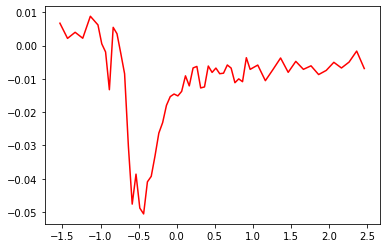

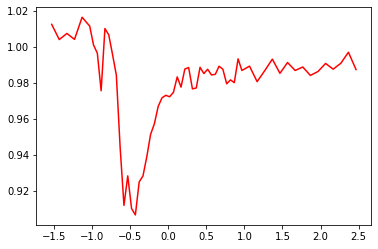

../Data/20201201/expid_TEY-hbn-298.50eV-65%-dscan410/410.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-298.50eV-65%-dscan410/../410.csv
TEY-hbn-298.75eV-65%%-dscan411 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-298.75eV-65%-dscan411 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-298.75eV-65%-dscan411/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298.75'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41

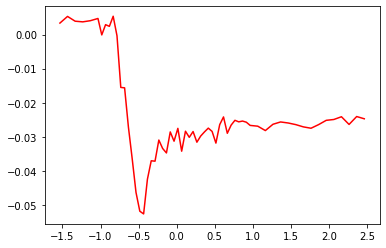

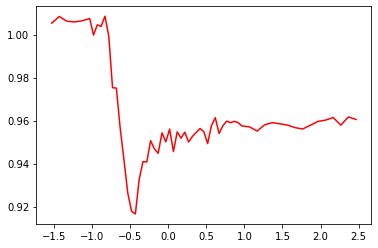

../Data/20201201/expid_TEY-hbn-298.75eV-65%-dscan411/411.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-298.75eV-65%-dscan411/../411.csv
TEY-hbn-299eV-65%%-dscan412 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-299eV-65%-dscan412 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-299eV-65%-dscan412/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['299'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -41.552

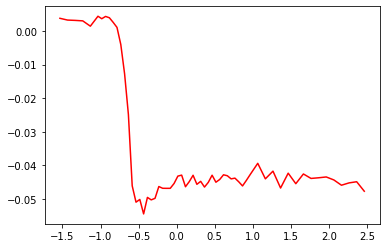

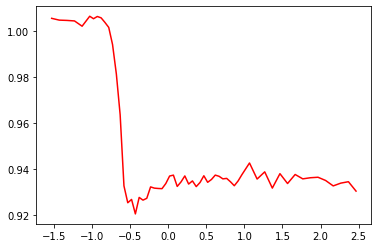

../Data/20201201/expid_TEY-hbn-299eV-65%-dscan412/412.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-299eV-65%-dscan412/../412.csv
TEY-hbn-nolaser-escan413 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-nolaser-escan413 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-nolaser-escan413/*MCP*.*
Number of Shots/File: 300
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.71 12300 / 12300 matched.
RepeatNumber == 0.0 12300 / 12300 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 6150 / 12300 matched.
LaserOFF (TimestampAbsSec%12 ==0) 6150 / 12300 matched.


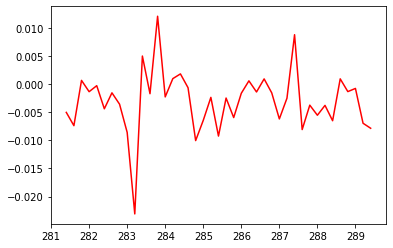

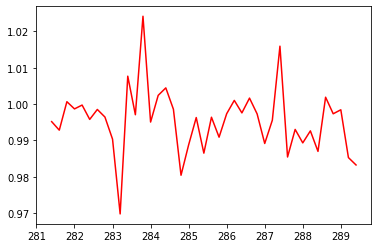

../Data/20201201/expid_TEY-hbn-nolaser-escan413/413.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-nolaser-escan413/../413.csv
TEY-hbn-299.25eV-65%%-dscan414 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-299.25eV-65%-dscan414 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-299.25eV-65%-dscan414/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['299.25'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -41.5

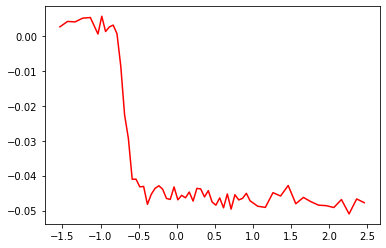

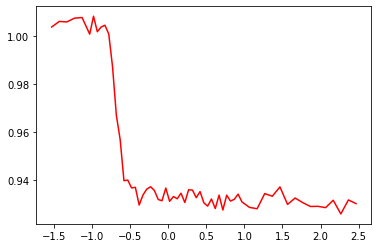

../Data/20201201/expid_TEY-hbn-299.25eV-65%-dscan414/414.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-299.25eV-65%-dscan414/../414.csv
TEY-hbn-299.50eV-65%%-dscan415 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-299.50eV-65%-dscan415 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-299.50eV-65%-dscan415/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['299.50'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41

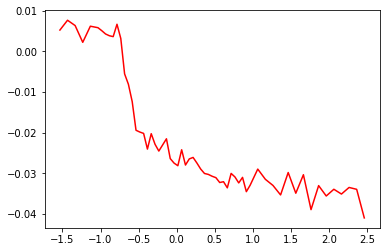

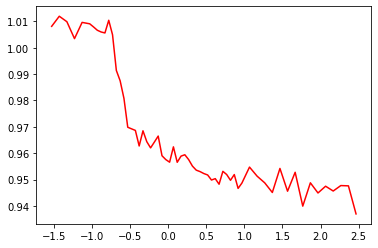

../Data/20201201/expid_TEY-hbn-299.50eV-65%-dscan415/415.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-299.50eV-65%-dscan415/../415.csv
TEY-hbn-299.75eV-65%%-dscan416 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-299.75eV-65%-dscan416 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-299.75eV-65%-dscan416/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['299.75'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41

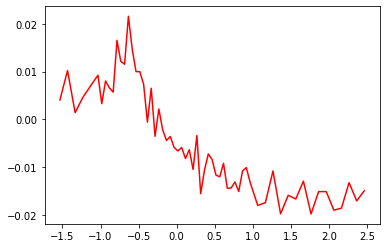

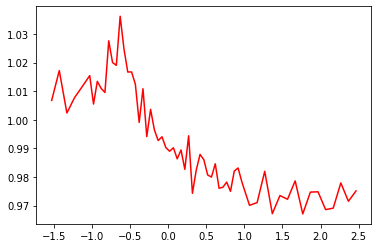

../Data/20201201/expid_TEY-hbn-299.75eV-65%-dscan416/416.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-299.75eV-65%-dscan416/../416.csv
TEY-hbn-300eV-65%%-dscan417 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-300eV-65%-dscan417 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-300eV-65%-dscan417/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['300'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -41.552

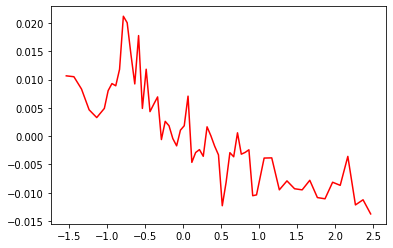

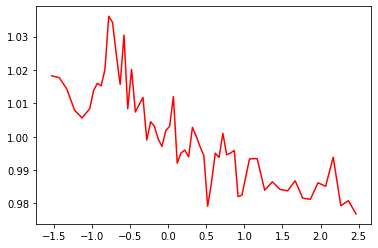

../Data/20201201/expid_TEY-hbn-300eV-65%-dscan417/417.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-300eV-65%-dscan417/../417.csv
TEY-hbn-300.5eV-65%%-dscan418 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-300.5eV-65%-dscan418 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-300.5eV-65%-dscan418/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['300.5'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -41.5

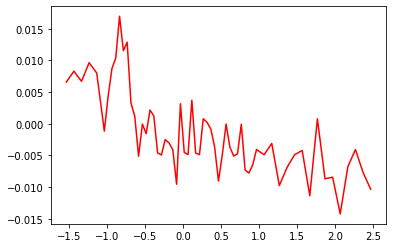

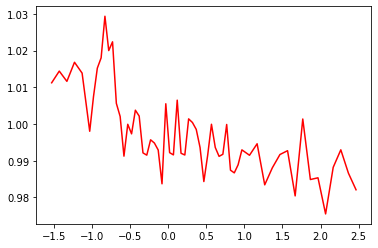

../Data/20201201/expid_TEY-hbn-300.5eV-65%-dscan418/418.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-300.5eV-65%-dscan418/../418.csv
TEY-hbn-301eV-65%%-dscan419 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-301eV-65%-dscan419 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-301eV-65%-dscan419/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['301'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -41.5525 

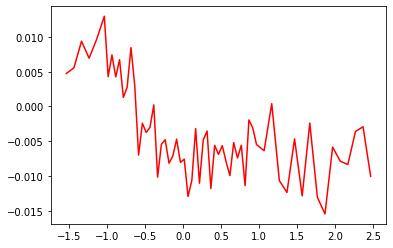

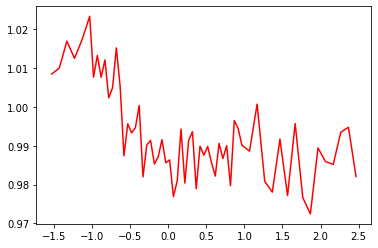

../Data/20201201/expid_TEY-hbn-301eV-65%-dscan419/419.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-301eV-65%-dscan419/../419.csv
TEY-hbn-299.25eV-65%%-dscan420 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-299.25eV-65%-dscan420 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-299.25eV-65%-dscan420/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['299.25'] 48000 / 48000 matched.
RepeatNumber == 0.0 48000 / 48000 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 24000 / 48000 matched.
LaserOFF (TimestampAbsSec%12 ==0) 24000 / 48000 matched.
DelayOfInterest [-43.06 -42.91 -42.76 -42.61 -42.46 -42.31 -42.16 -42.01 -41.86 -41.71
 -41.56 -41.41 -41.26 -41.11 -40.96 -40.81 -40.66 -40.51 -40.36 -40.21
 -

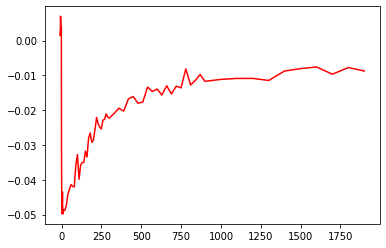

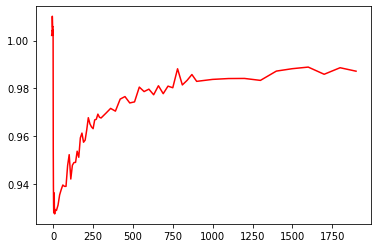

../Data/20201201/expid_TEY-hbn-299.25eV-65%-dscan420/420.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-299.25eV-65%-dscan420/../420.csv
TEY-hbn-6ps-65%%-escan421 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-6ps-65%-escan421 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-6ps-65%-escan421/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -40.66 48600 / 48600 matched.
RepeatNumber == 0.0 48600 / 48600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 24300 / 48600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 24300 / 48600 matched.


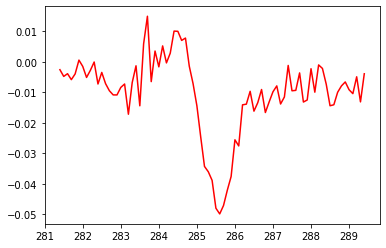

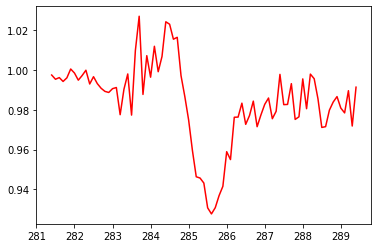

../Data/20201201/expid_TEY-hbn-6ps-65%-escan421/421.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-6ps-65%-escan421/../421.csv
TEY-hbn-130ps-65%%-escan422 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-130ps-65%-escan422 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-130ps-65%-escan422/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -22.08 48600 / 48600 matched.
RepeatNumber == 0.0 48600 / 48600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 24300 / 48600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 24300 / 48600 matched.


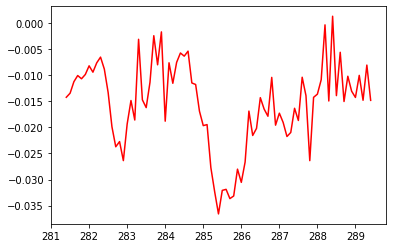

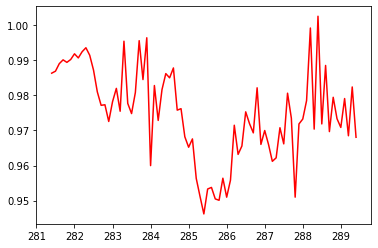

../Data/20201201/expid_TEY-hbn-130ps-65%-escan422/422.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-130ps-65%-escan422/../422.csv
TEY-hbn-1500ps-65%%-escan423 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-1500ps-65%-escan423 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-1500ps-65%-escan423/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == 183.22 48600 / 48600 matched.
RepeatNumber == 0.0 48600 / 48600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 24300 / 48600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 24300 / 48600 matched.


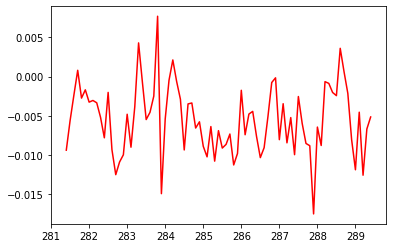

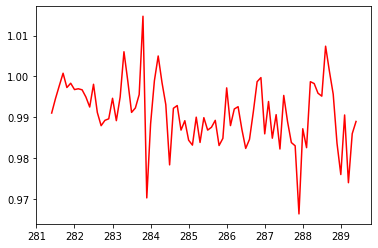

../Data/20201201/expid_TEY-hbn-1500ps-65%-escan423/423.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-1500ps-65%-escan423/../423.csv
TEY-hbn--0.4ps-65%%-escan424 will be processed.
Files in ../Data/20201201/expid_TEY-hbn--0.4ps-65%-escan424 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn--0.4ps-65%-escan424/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.62 42600 / 42600 matched.
RepeatNumber == 0.0 42600 / 42600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 21300 / 42600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 21300 / 42600 matched.


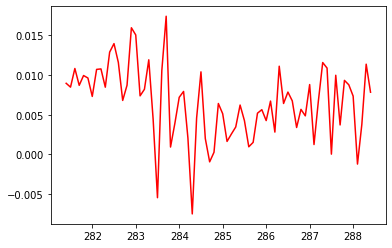

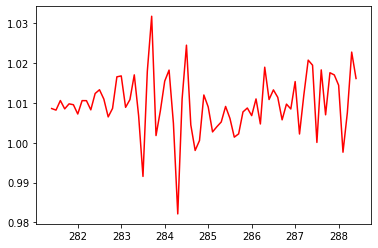

../Data/20201201/expid_TEY-hbn--0.4ps-65%-escan424/424.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn--0.4ps-65%-escan424/../424.csv
TEY-hbn--0.2ps-65%%-escan425 will be processed.
Files in ../Data/20201201/expid_TEY-hbn--0.2ps-65%-escan425 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn--0.2ps-65%-escan425/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.59 42600 / 42600 matched.
RepeatNumber == 0.0 42600 / 42600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 21300 / 42600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 21300 / 42600 matched.


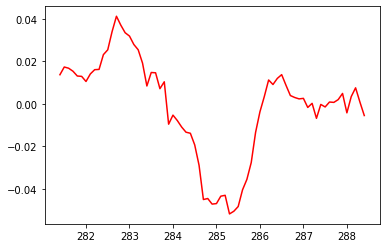

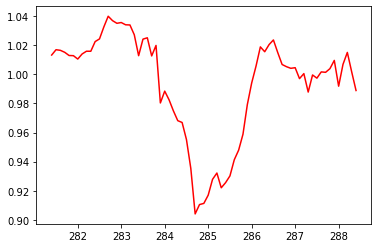

../Data/20201201/expid_TEY-hbn--0.2ps-65%-escan425/425.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn--0.2ps-65%-escan425/../425.csv
TEY-hbn-0ps-65%%-escan426 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-0ps-65%-escan426 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-0ps-65%-escan426/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.56 42600 / 42600 matched.
RepeatNumber == 0.0 42600 / 42600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 21300 / 42600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 21300 / 42600 matched.


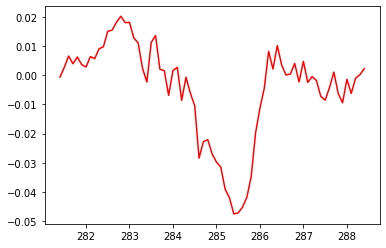

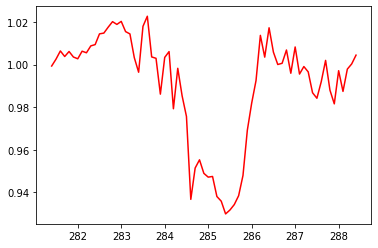

../Data/20201201/expid_TEY-hbn-0ps-65%-escan426/426.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-0ps-65%-escan426/../426.csv
TEY-hbn-0.2ps-65%%-escan427 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-0.2ps-65%-escan427 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-0.2ps-65%-escan427/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.53 42600 / 42600 matched.
RepeatNumber == 0.0 42600 / 42600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 21300 / 42600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 21300 / 42600 matched.


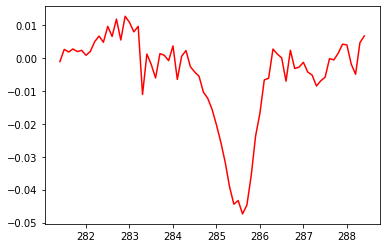

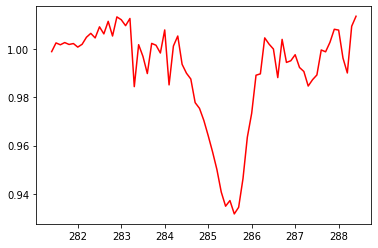

../Data/20201201/expid_TEY-hbn-0.2ps-65%-escan427/427.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-0.2ps-65%-escan427/../427.csv
TEY-hbn-298.4eV-65%%-dscan428 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-298.4eV-65%-dscan428 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-298.4eV-65%-dscan428/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298.4'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -41.5

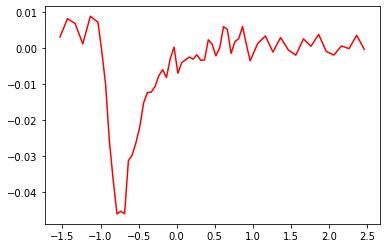

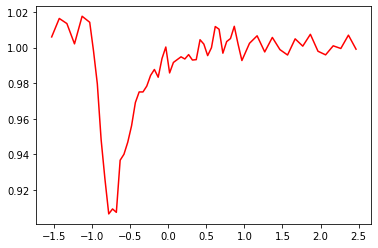

../Data/20201201/expid_TEY-hbn-298.4eV-65%-dscan428/428.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-298.4eV-65%-dscan428/../428.csv
TEY-hbn--0.6ps-65%%-escan429 will be processed.
Files in ../Data/20201201/expid_TEY-hbn--0.6ps-65%-escan429 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn--0.6ps-65%-escan429/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.65 42600 / 42600 matched.
RepeatNumber == 0.0 42600 / 42600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 21300 / 42600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 21300 / 42600 matched.


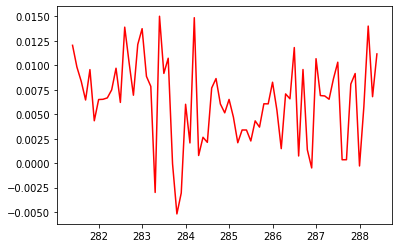

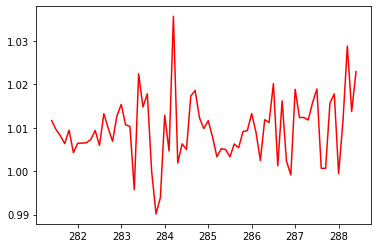

../Data/20201201/expid_TEY-hbn--0.6ps-65%-escan429/429.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn--0.6ps-65%-escan429/../429.csv
TEY-hbn-0.4ps-65%%-escan430 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-0.4ps-65%-escan430 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-0.4ps-65%-escan430/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.5 42600 / 42600 matched.
RepeatNumber == 0.0 42600 / 42600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 21300 / 42600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 21300 / 42600 matched.


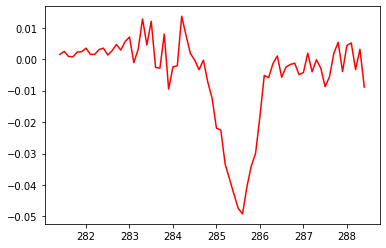

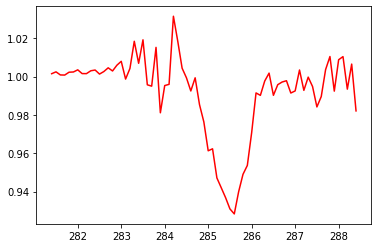

../Data/20201201/expid_TEY-hbn-0.4ps-65%-escan430/430.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-0.4ps-65%-escan430/../430.csv
TEY-hbn--0.2ps-65%%-escan431 will be processed.
Files in ../Data/20201201/expid_TEY-hbn--0.2ps-65%-escan431 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn--0.2ps-65%-escan431/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.59 42600 / 42600 matched.
RepeatNumber == 0.0 42600 / 42600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 21300 / 42600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 21300 / 42600 matched.


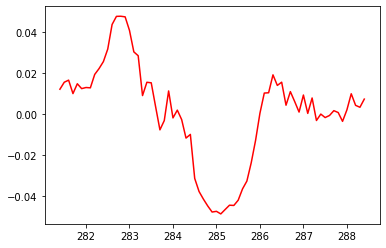

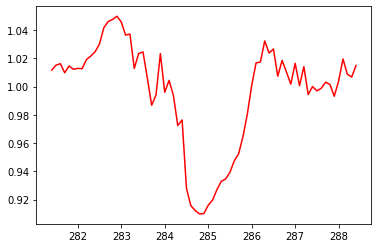

../Data/20201201/expid_TEY-hbn--0.2ps-65%-escan431/431.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn--0.2ps-65%-escan431/../431.csv
TEY-hbn-1ps-65%%-escan432 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-1ps-65%-escan432 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-1ps-65%-escan432/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.41 4800 / 4800 matched.
RepeatNumber == 0.0 4800 / 4800 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 2400 / 4800 matched.
LaserOFF (TimestampAbsSec%12 ==0) 2400 / 4800 matched.


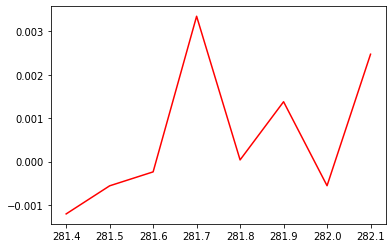

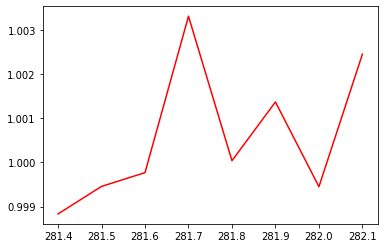

../Data/20201201/expid_TEY-hbn-1ps-65%-escan432/432.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-1ps-65%-escan432/../432.csv
TEY-hbn--0.4ps-65%%-escan433 will be processed.
Files in ../Data/20201201/expid_TEY-hbn--0.4ps-65%-escan433 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn--0.4ps-65%-escan433/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.62 42600 / 42600 matched.
RepeatNumber == 0.0 42600 / 42600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 21300 / 42600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 21300 / 42600 matched.


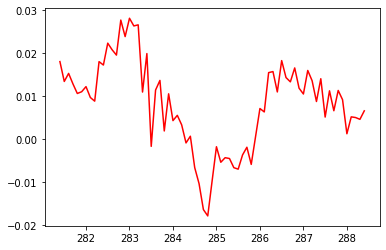

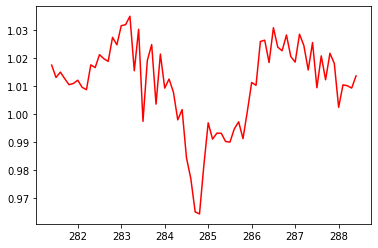

../Data/20201201/expid_TEY-hbn--0.4ps-65%-escan433/433.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn--0.4ps-65%-escan433/../433.csv
TEY-hbn-298.4eV-65%%-dscan434 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-298.4eV-65%-dscan434 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-298.4eV-65%-dscan434/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298.4'] 28200 / 28200 matched.
RepeatNumber == 0.0 28200 / 28200 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 14100 / 28200 matched.
LaserOFF (TimestampAbsSec%12 ==0) 14100 / 28200 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -41

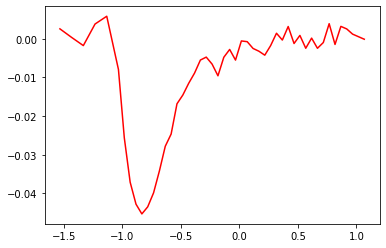

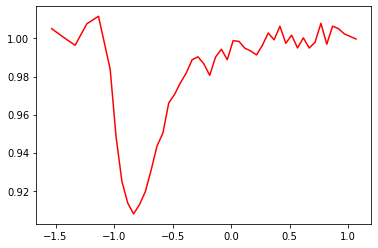

../Data/20201201/expid_TEY-hbn-298.4eV-65%-dscan434/434.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-298.4eV-65%-dscan434/../434.csv
TEY-hbn--1ps-65%%-escan435 will be processed.
Files in ../Data/20201201/expid_TEY-hbn--1ps-65%-escan435 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn--1ps-65%-escan435/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.71 42600 / 42600 matched.
RepeatNumber == 0.0 42600 / 42600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 21300 / 42600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 21300 / 42600 matched.


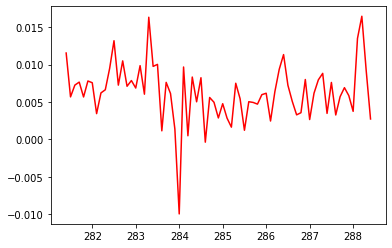

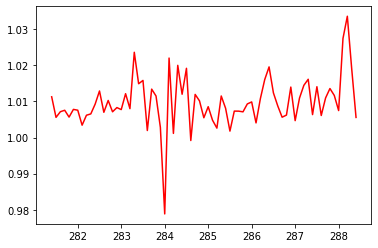

../Data/20201201/expid_TEY-hbn--1ps-65%-escan435/435.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn--1ps-65%-escan435/../435.csv
TEY-hbn-1ps-65%%-escan436 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-1ps-65%-escan436 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-1ps-65%-escan436/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.41 42600 / 42600 matched.
RepeatNumber == 0.0 42600 / 42600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 21300 / 42600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 21300 / 42600 matched.


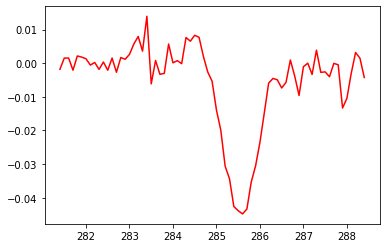

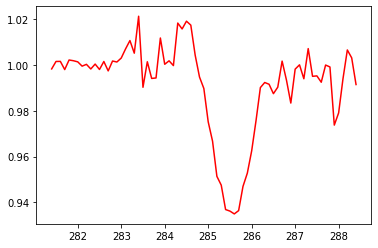

../Data/20201201/expid_TEY-hbn-1ps-65%-escan436/436.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-1ps-65%-escan436/../436.csv
TEY-hbn-298.4eV-65%%-dscan437 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-298.4eV-65%-dscan437 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-298.4eV-65%-dscan437/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['298.4'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -41.5525 

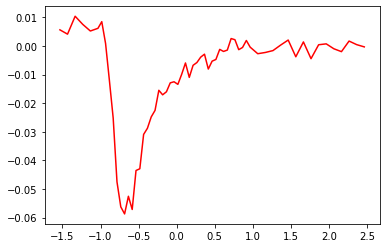

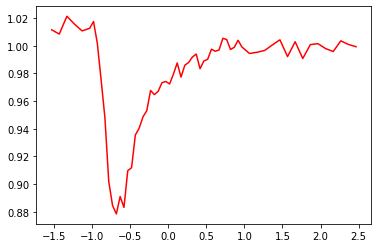

../Data/20201201/expid_TEY-hbn-298.4eV-65%-dscan437/437.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-298.4eV-65%-dscan437/../437.csv
TEY-hbn-299.25eV-65%%-dscan438 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-299.25eV-65%-dscan438 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-299.25eV-65%-dscan438/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['299.25'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.5

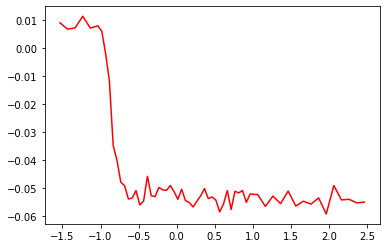

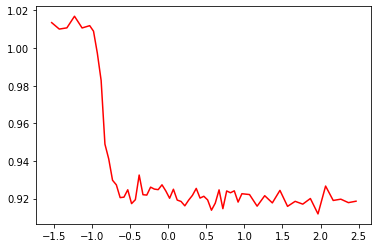

../Data/20201201/expid_TEY-hbn-299.25eV-65%-dscan438/438.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-299.25eV-65%-dscan438/../438.csv
TEY-hbn-296.25eV-65%%-dscan439 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-296.25eV-65%-dscan439 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-296.25eV-65%-dscan439/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['296.25'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41

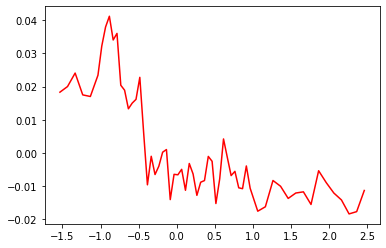

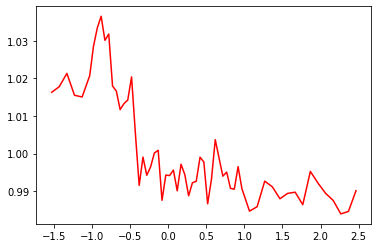

../Data/20201201/expid_TEY-hbn-296.25eV-65%-dscan439/439.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-296.25eV-65%-dscan439/../439.csv
TEY-hbn-300eV-65%%-dscan440 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-300eV-65%-dscan440 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-300eV-65%-dscan440/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: True
Flg_EnergyScan: False
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? True
Is this Energy scan? False
3 Flg_DelayScan=True
3  Energy ==['300'] 36600 / 36600 matched.
RepeatNumber == 0.0 36600 / 36600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 18300 / 36600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 18300 / 36600 matched.
DelayOfInterest [-41.71   -41.695  -41.68   -41.665  -41.65   -41.635  -41.6275 -41.62
 -41.6125 -41.605  -41.5975 -41.59   -41.5825 -41.575  -41.5675 -41.56
 -41.552

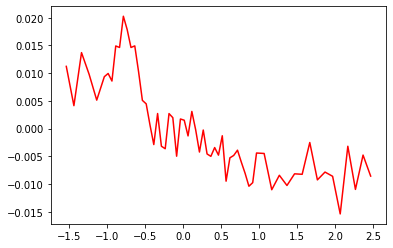

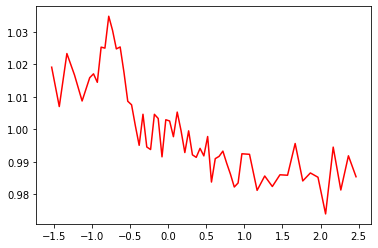

../Data/20201201/expid_TEY-hbn-300eV-65%-dscan440/440.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-300eV-65%-dscan440/../440.csv
TEY-hbn--0.27ps-65%%-escan441 will be processed.
Files in ../Data/20201201/expid_TEY-hbn--0.27ps-65%-escan441 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn--0.27ps-65%-escan441/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.6 42600 / 42600 matched.
RepeatNumber == 0.0 42600 / 42600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 21300 / 42600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 21300 / 42600 matched.


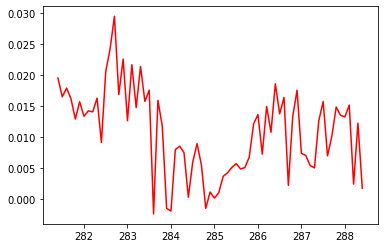

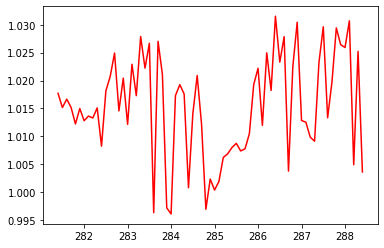

../Data/20201201/expid_TEY-hbn--0.27ps-65%-escan441/441.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn--0.27ps-65%-escan441/../441.csv
TEY-hbn-3ps-65%%-escan442 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-3ps-65%-escan442 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-3ps-65%-escan442/*MCP*.*
Number of Shots/File: 600
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
2 Flg_EnergyScan=True
2  DelayStagePos == -41.11 42600 / 42600 matched.
RepeatNumber == 0.0 42600 / 42600 matched.
Is this Modulaiton scan? True
LaserON (TimestampAbsSec%12 ==6) 21300 / 42600 matched.
LaserOFF (TimestampAbsSec%12 ==0) 21300 / 42600 matched.


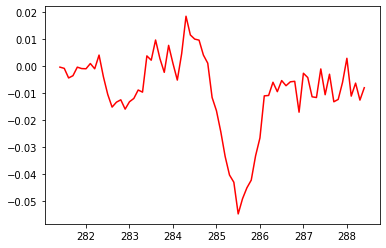

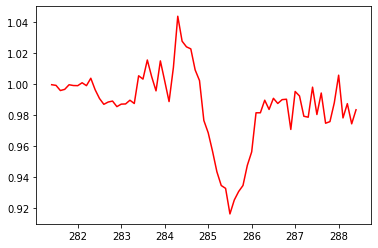

../Data/20201201/expid_TEY-hbn-3ps-65%-escan442/442.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-3ps-65%-escan442/../442.csv


In [ ]:
##SHIFT5  20201130
#Energy Scan Gr/hBN/Cu
PALdataset_to_CSV('TEY-hbn-escan336')
PALdataset_to_CSV('TEY-hbn-298.4eV-65%%-dscan337')
PALdataset_to_CSV('TEY-hbn-0ps-65%%-escan338')
PALdataset_to_CSV('TEY-hbn-0ps-65%%-escan339')
PALdataset_to_CSV('TEY-hbn-0.15ps-65%%-escan340')
PALdataset_to_CSV('TEY-hbn-0.3ps-65%%-escan341')
PALdataset_to_CSV('TEY-hbn-0.7ps-65%%-escan342')
PALdataset_to_CSV('TEY-hbn-1.2ps-65%%-escan343')
PALdataset_to_CSV('TEY-hbn-3ps-65%%-escan344')
PALdataset_to_CSV('TEY-hbn--1.2ps-65%%-escan345')
#PALdataset_to_CSV('TEY-hbn-0ps-65%%-escan346')
PALdataset_to_CSV('TEY-hbn-298.4eV-65%%-dscan347')
PALdataset_to_CSV('TEY-hbn-299.3eV-65%%-dscan348')
PALdataset_to_CSV('TEY-hbn-299.8eV-65%%-dscan349')
PALdataset_to_CSV('TEY-hbn-296.4eV-65%%-dscan350')
#expid_TEY-hbn-65%-2dscan351
#expid_TEY-hbn-60%-2dscan352
#expid_TEY-hbn-55%-2dscan353
#expid_TEY-hbn-50%-2dscan354
#expid_TEY-hbn-45%-2dscan355
#expid_TEY-hbn-40%-2dscan356
#expid_TEY-hbn-35%-2dscan357
#expid_TEY-hbn-30%-2dscan358
#expid_TEY-hbn-25%-2dscan359
#PALdataset_to_CSV('TEY-foil-298.4eV-65%%-dscan360')
#Delay Scan Gr/Cu
PALdataset_to_CSV('TEY-foil-0ps-65%%-escan361')
PALdataset_to_CSV('TEY-foil-295.5eV-65%%-dscan362')
PALdataset_to_CSV('TEY-foil-295.75eV-65%%-dscan363')
PALdataset_to_CSV('TEY-foil-296eV-65%%-dscan364')
PALdataset_to_CSV('TEY-foil-296.25eV-65%%-dscan365')
PALdataset_to_CSV('TEY-foil-296.5eV-65%%-dscan366')
PALdataset_to_CSV('TEY-foil-296.75eV-65%%-dscan367')
PALdataset_to_CSV('TEY-foil-297eV-65%%-dscan368')
PALdataset_to_CSV('TEY-foil-297.25eV-65%%-dscan369')
PALdataset_to_CSV('TEY-foil-297.5eV-65%%-dscan370')
PALdataset_to_CSV('TEY-foil-297.75eV-65%%-dscan371')
PALdataset_to_CSV('TEY-foil-298eV-65%%-dscan372')
PALdataset_to_CSV('TEY-foil-298.25eV-65%%-dscan373')
PALdataset_to_CSV('TEY-foil-298.5eV-65%%-dscan374')
#PALdataset_to_CSV('TEY-foil-298.75eV-65%%-dscan375')
PALdataset_to_CSV('TEY-foil-299eV-65%%-dscan376')
PALdataset_to_CSV('TEY-foil-299.25eV-65%%-dscan377')
PALdataset_to_CSV('TEY-foil-299.5eV-65%%-dscan378')
PALdataset_to_CSV('TEY-foil-300eV-65%%-dscan379')
PALdataset_to_CSV('TEY-foil-300.5eV-65%%-dscan380')
PALdataset_to_CSV('TEY-foil-301eV-65%%-dscan381')
PALdataset_to_CSV('TEY-foil-298.4V-65%%-dscan382')
#expid_TEY-foil-65%-2dscan383
#expid_TEY-foil-60%-2dscan384
#expid_TEY-foil-55%-2dscan385
#expid_TEY-foil-50%-2dscan386
#expid_TEY-foil-45%-2dscan387
#expid_TEY-foil-40%-2dscan388
#expid_TEY-foil-35%-2dscan389
#expid_TEY-foil-30%-2dscan390
#expid_TEY-foil-25%-2dscan391
#expid_TEY-foil-299.3eV-65%-dscan392
#expid_TEY-foil-299.8eV-65%-dscan393
#expid_TEY-foil-296.4eV-65%-dscan394

##SHIFT6  20201201 Energy Scan
#s-pol
PALdataset_to_CSV('TEY-hbn-295.5eV-65%%-dscan397')
PALdataset_to_CSV('TEY-hbn--1ps-65%%-escan398')
PALdataset_to_CSV('TEY-hbn-295.75eV-65%%-dscan399')
PALdataset_to_CSV('TEY-hbn-296eV-65%%-dscan400')
PALdataset_to_CSV('TEY-hbn-296.25eV-65%%-dscan401')
PALdataset_to_CSV('TEY-hbn-296.5eV-65%%-dscan402')
PALdataset_to_CSV('TEY-hbn-296.75eV-65%%-dscan403')
PALdataset_to_CSV('TEY-hbn-297eV-65%%-dscan404')
PALdataset_to_CSV('TEY-hbn-297.25eV-65%%-dscan405')
PALdataset_to_CSV('TEY-hbn-297.50eV-65%%-dscan406')
PALdataset_to_CSV('TEY-hbn-297.75eV-65%%-dscan407')
PALdataset_to_CSV('TEY-hbn-298eV-65%%-dscan408')
PALdataset_to_CSV('TEY-hbn-298.25eV-65%%-dscan409')
PALdataset_to_CSV('TEY-hbn-298.50eV-65%%-dscan410')
PALdataset_to_CSV('TEY-hbn-298.75eV-65%%-dscan411')
PALdataset_to_CSV('TEY-hbn-299eV-65%%-dscan412')
PALdataset_to_CSV('TEY-hbn-nolaser-escan413')
PALdataset_to_CSV('TEY-hbn-299.25eV-65%%-dscan414')
PALdataset_to_CSV('TEY-hbn-299.50eV-65%%-dscan415')
PALdataset_to_CSV('TEY-hbn-299.75eV-65%%-dscan416')
PALdataset_to_CSV('TEY-hbn-300eV-65%%-dscan417')
PALdataset_to_CSV('TEY-hbn-300.5eV-65%%-dscan418')
PALdataset_to_CSV('TEY-hbn-301eV-65%%-dscan419')
PALdataset_to_CSV('TEY-hbn-299.25eV-65%%-dscan420')
PALdataset_to_CSV('TEY-hbn-6ps-65%%-escan421')
PALdataset_to_CSV('TEY-hbn-130ps-65%%-escan422')
PALdataset_to_CSV('TEY-hbn-1500ps-65%%-escan423')
PALdataset_to_CSV('TEY-hbn--0.4ps-65%%-escan424')
PALdataset_to_CSV('TEY-hbn--0.2ps-65%%-escan425')
PALdataset_to_CSV('TEY-hbn-0ps-65%%-escan426')
PALdataset_to_CSV('TEY-hbn-0.2ps-65%%-escan427')
PALdataset_to_CSV('TEY-hbn-298.4eV-65%%-dscan428')
PALdataset_to_CSV('TEY-hbn--0.6ps-65%%-escan429')
PALdataset_to_CSV('TEY-hbn-0.4ps-65%%-escan430')
PALdataset_to_CSV('TEY-hbn--0.2ps-65%%-escan431')
PALdataset_to_CSV('TEY-hbn-1ps-65%%-escan432')
PALdataset_to_CSV('TEY-hbn--0.4ps-65%%-escan433')
PALdataset_to_CSV('TEY-hbn-298.4eV-65%%-dscan434')
PALdataset_to_CSV('TEY-hbn--1ps-65%%-escan435')
PALdataset_to_CSV('TEY-hbn-1ps-65%%-escan436')
#p-pol
PALdataset_to_CSV('TEY-hbn-298.4eV-65%%-dscan437')
PALdataset_to_CSV('TEY-hbn-299.25eV-65%%-dscan438')
PALdataset_to_CSV('TEY-hbn-296.25eV-65%%-dscan439')
PALdataset_to_CSV('TEY-hbn-300eV-65%%-dscan440')
PALdataset_to_CSV('TEY-hbn--0.27ps-65%%-escan441')
PALdataset_to_CSV('TEY-hbn-3ps-65%%-escan442')

TEY-hbn--0.4ps-65%%-escan424 will be processed.
Files in ../Data/20201201/expid_TEY-hbn--0.4ps-65%-escan424 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn--0.4ps-65%-escan424/*MCP*.*
Number of Shots/File: 600
Numer of Elements/Column: 42600
Delay_mm: [-41.62]
Delay_ps: [-0.93333333]
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Region: [1]
Energy: [295.  295.1 295.2 295.3 295.4 295.5 295.6 295.7 295.8 295.9 296.  296.1
 296.2 296.3 296.4 296.5 296.6 296.7 296.8 296.9 297.  297.1 297.2 297.3
 297.4 297.5 297.6 297.7 297.8 297.9 298.  298.1 298.2 298.3 298.4 298.5
 298.6 298.7 298.8 298.9 299.  299.1 299.2 299.3 299.4 299.5 299.6 299.7
 299.8 299.9 300.  300.1 300.2 300.3 300.4 300.5 300.6 300.7 300.8 300.9
 301.  301.1 301.2 301.3 301.4 301.5 301.6 301.7 301.8 301.9 302. ]
Repeat: [0.]
Is this Delay scan? False
Is this Energy scan? True
DelayStagePos == -41.62 42600 / 42

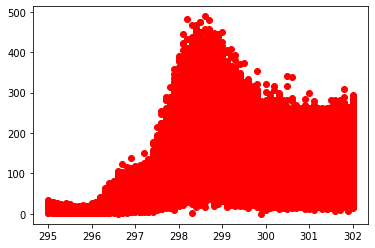

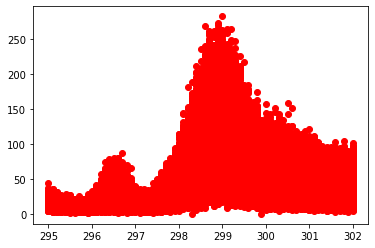

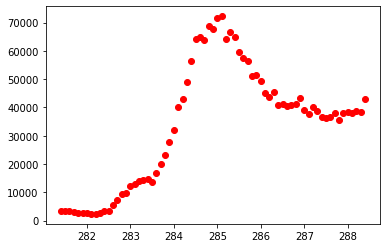

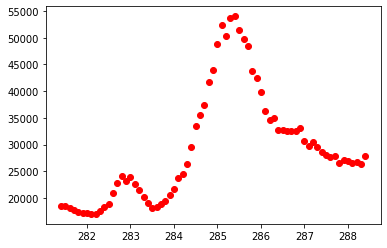

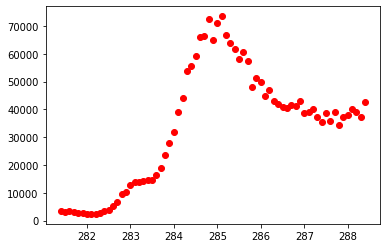

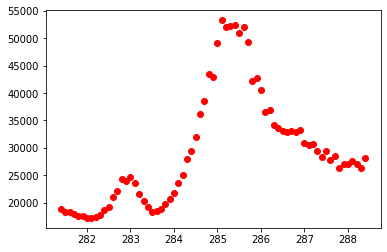

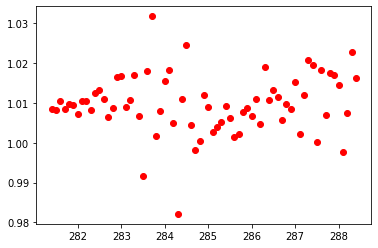

../Data/20201201/expid_TEY-hbn--0.4ps-65%-escan424/424.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn--0.4ps-65%-escan424/../424.csv
TEY-hbn--0.2ps-65%%-escan425 will be processed.
Files in ../Data/20201201/expid_TEY-hbn--0.2ps-65%-escan425 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn--0.2ps-65%-escan425/*MCP*.*
Number of Shots/File: 600
Numer of Elements/Column: 42600
Delay_mm: [-41.59]
Delay_ps: [-0.73333333]
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Region: [1]
Energy: [295.  295.1 295.2 295.3 295.4 295.5 295.6 295.7 295.8 295.9 296.  296.1
 296.2 296.3 296.4 296.5 296.6 296.7 296.8 296.9 297.  297.1 297.2 297.3
 297.4 297.5 297.6 297.7 297.8 297.9 298.  298.1 298.2 298.3 298.4 298.5
 298.6 298.7 298.8 298.9 299.  299.1 299.2 299.3 299.4 299.5 299.6 299.7
 299.8 299.9 300.  300.1 300.2 300.3 300.4 300.5 300.6 300.7 300.8 300.9
 301.  301.1 301.2 301

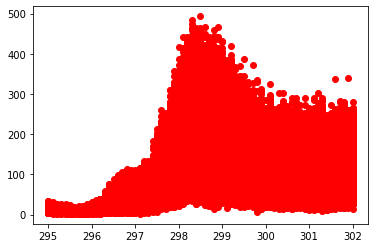

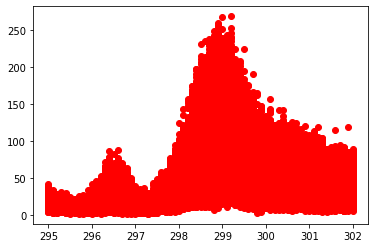

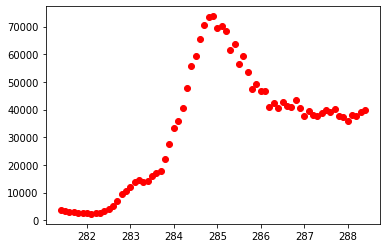

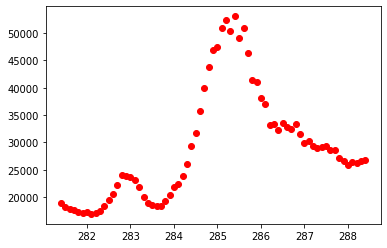

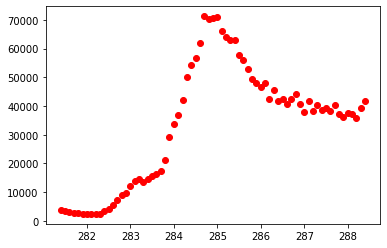

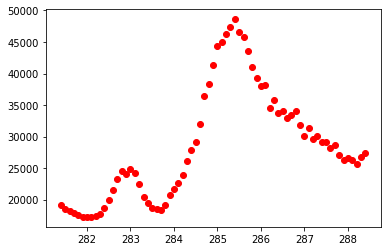

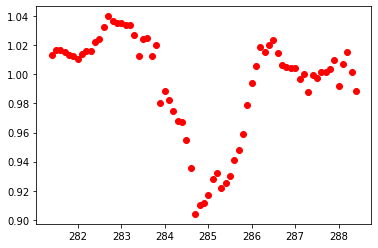

../Data/20201201/expid_TEY-hbn--0.2ps-65%-escan425/425.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn--0.2ps-65%-escan425/../425.csv
TEY-hbn-3ps-65%%-escan344 will be processed.
Files in ../Data/20201130/expid_TEY-hbn-3ps-65%-escan344 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201130/expid_TEY-hbn-3ps-65%-escan344/*MCP*.*
Number of Shots/File: 600
Numer of Elements/Column: 48600
Delay_mm: [-41.038]
Delay_ps: [2.94666667]
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Region: [1]
Energy: [295.  295.1 295.2 295.3 295.4 295.5 295.6 295.7 295.8 295.9 296.  296.1
 296.2 296.3 296.4 296.5 296.6 296.7 296.8 296.9 297.  297.1 297.2 297.3
 297.4 297.5 297.6 297.7 297.8 297.9 298.  298.1 298.2 298.3 298.4 298.5
 298.6 298.7 298.8 298.9 299.  299.1 299.2 299.3 299.4 299.5 299.6 299.7
 299.8 299.9 300.  300.1 300.2 300.3 300.4 300.5 300.6 300.7 300.8 300.9
 301.  301.1 301.2 301.3 301.4 

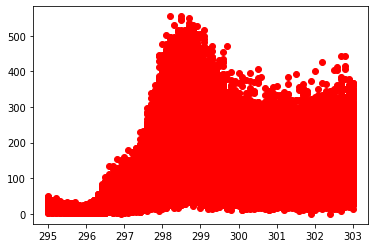

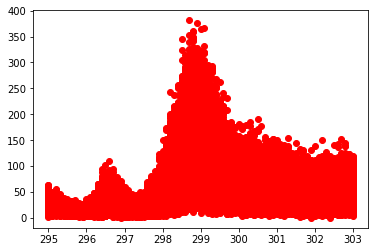

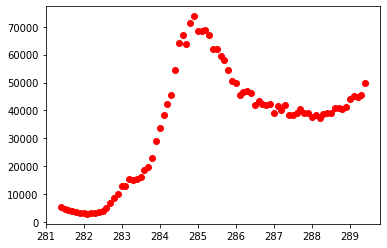

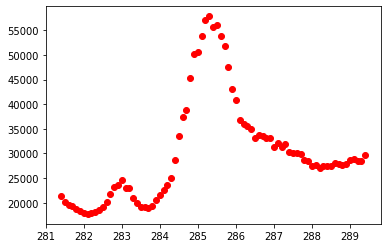

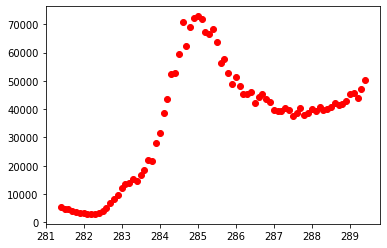

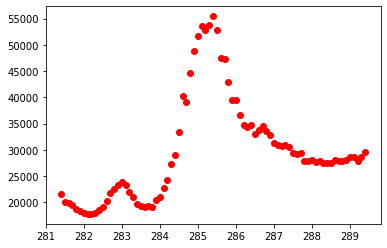

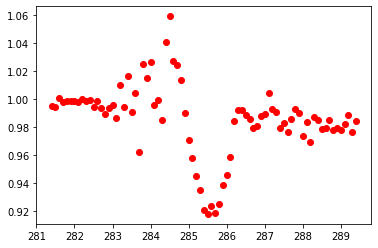

../Data/20201130/expid_TEY-hbn-3ps-65%-escan344/344.csv
Data Frame was saved as ../Data/20201130/expid_TEY-hbn-3ps-65%-escan344/../344.csv
TEY-hbn--0.27ps-65%%-escan441 will be processed.
Files in ../Data/20201201/expid_TEY-hbn--0.27ps-65%-escan441 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn--0.27ps-65%-escan441/*MCP*.*
Number of Shots/File: 600
Numer of Elements/Column: 42600
Delay_mm: [-41.6]
Delay_ps: [-0.8]
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Region: [1]
Energy: [295.  295.1 295.2 295.3 295.4 295.5 295.6 295.7 295.8 295.9 296.  296.1
 296.2 296.3 296.4 296.5 296.6 296.7 296.8 296.9 297.  297.1 297.2 297.3
 297.4 297.5 297.6 297.7 297.8 297.9 298.  298.1 298.2 298.3 298.4 298.5
 298.6 298.7 298.8 298.9 299.  299.1 299.2 299.3 299.4 299.5 299.6 299.7
 299.8 299.9 300.  300.1 300.2 300.3 300.4 300.5 300.6 300.7 300.8 300.9
 301.  301.1 301.2 301.3 301.4 30

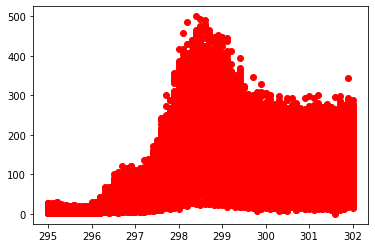

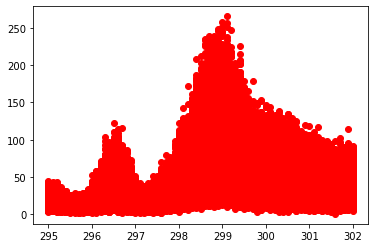

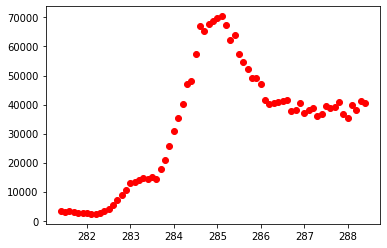

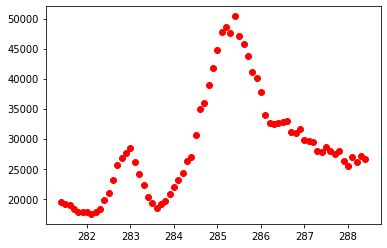

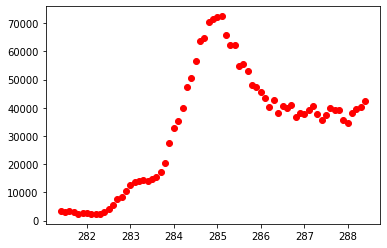

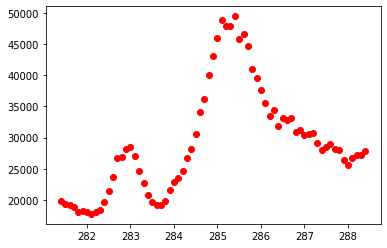

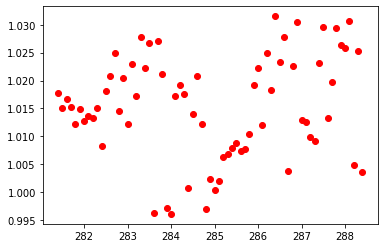

../Data/20201201/expid_TEY-hbn--0.27ps-65%-escan441/441.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn--0.27ps-65%-escan441/../441.csv
TEY-hbn-3ps-65%%-escan442 will be processed.
Files in ../Data/20201201/expid_TEY-hbn-3ps-65%-escan442 will be loaded.
LONQuery (TimestampAbsSec%12 ==6)
LOFFQuery (TimestampAbsSec%12 ==0)
../Data/20201201/expid_TEY-hbn-3ps-65%-escan442/*MCP*.*
Number of Shots/File: 600
Numer of Elements/Column: 42600
Delay_mm: [-41.11]
Delay_ps: [2.46666667]
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: True
Flg_NegativeDelayRef: False
Region: [1]
Energy: [295.  295.1 295.2 295.3 295.4 295.5 295.6 295.7 295.8 295.9 296.  296.1
 296.2 296.3 296.4 296.5 296.6 296.7 296.8 296.9 297.  297.1 297.2 297.3
 297.4 297.5 297.6 297.7 297.8 297.9 298.  298.1 298.2 298.3 298.4 298.5
 298.6 298.7 298.8 298.9 299.  299.1 299.2 299.3 299.4 299.5 299.6 299.7
 299.8 299.9 300.  300.1 300.2 300.3 300.4 300.5 300.6 300.7 300.8 300.9
 301.  301.1 301.2 301.3 301.4

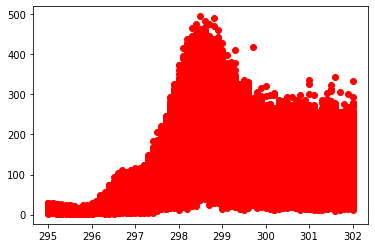

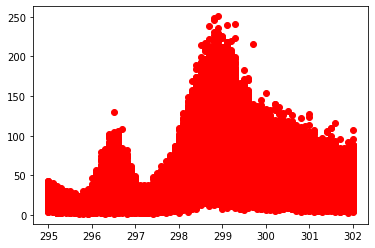

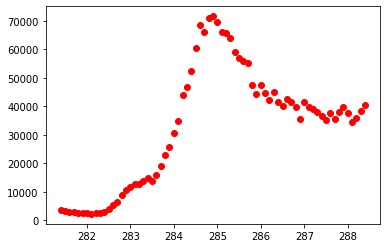

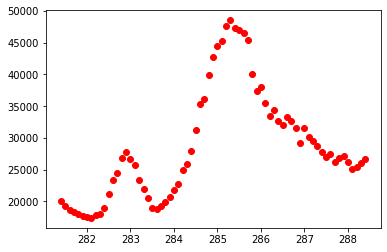

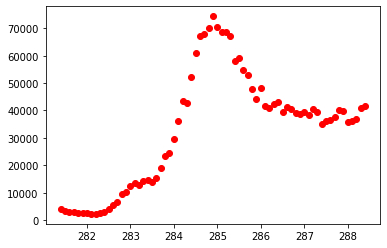

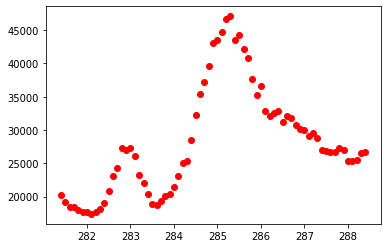

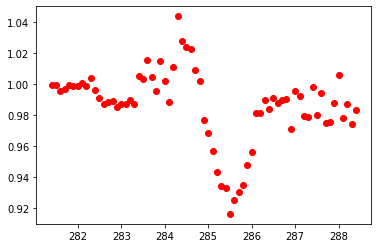

../Data/20201201/expid_TEY-hbn-3ps-65%-escan442/442.csv
Data Frame was saved as ../Data/20201201/expid_TEY-hbn-3ps-65%-escan442/../442.csv


In [ ]:
import configparser
config = configparser.ConfigParser()
#config.read('PALanaE.ini')

config.read('PALanaE.ini')
input_f=config.get('PALana','fileset')
print(input_f,'will be processed.')

fileset=input_f
dataset=config.get(input_f,'dataset')
prefix=config.get(input_f,'prefix')
prefix=prefix+dataset
print('Files in',prefix,'will be loaded.')
EnergyOfInterest=config.get(input_f,'EnergyOfInterest').split('\n')
DelayOfInterest=config.get(input_f,'DelayOfInterest').split('\n')
Repeat_list=config.get(input_f,'Repeat_list')
LOFFpos=config.get(input_f,'LOFFpos')
t0pos=config.get(input_f,'t0pos')
datasetnumber=int(config.get(input_f,'datasetnumber'))

Flg_EnergyScan=bool(int(config.get(input_f,'Flg_EnergyScan')))
Flg_DelayScan=bool(int(config.get(input_f,'Flg_DelayScan')))
Flg_ModulationScan=bool(int(config.get(input_f,'Flg_ModulationScan')))
Flg_NegativeDelayRef=bool(int(config.get(input_f,'Flg_NegativeDelayRef')))

Flg_EnergyOffset=bool(int(config.get(input_f,'Flg_EnergyOffset')))
Flg_DarkOffsetI0=bool(int(config.get(input_f,'Flg_DarkOffsetI0')))
Flg_DarkOffsetI1=bool(int(config.get(input_f,'Flg_DarkOffsetI1')))

Var_EnergyOffset=float(config.get(input_f,'Var_EnergyOffset'))
Var_DarkOffsetI0=float(config.get(input_f,'Var_DarkOffsetI0'))
Var_DarkOffsetI1=float(config.get(input_f,'Var_DarkOffsetI1'))

Flg_ApplyI0NotchFilter=bool(config.get(input_f,'Flg_ApplyI0NotchFilter'))
Var_I0_NotchFilter_min=float(config.get(input_f,'Var_I0_NotchFilter_min'))
Var_I0_NotchFilter_max=float(config.get(input_f,'Var_I0_NotchFilter_max'))

#Define the condition for Laser ON, Laser OFF
if Flg_NegativeDelayRef==True:
    LONQuery = '(DelayStagePos >'+str(LOFFpos)+')'
    LOFFQuery = '(DelayStagePos =='+str(LOFFpos)+')'
if Flg_ModulationScan==True:
    LONQuery = '(TimestampAbsSec%12 ==0)'
    LOFFQuery = '(TimestampAbsSec%12 ==6)'



In [ ]:
# Read PAL files and make Data Frame
import glob
import numpy as np
import itertools
import pandas as pd

print(prefix+'/*MCP*.*')
I0_FileNames = glob.glob(prefix+'/*MCP*.*')
I1_FileNames = []
ShotList = []

for i in range(len(I0_FileNames)):
    FN = str(I0_FileNames[i])
    I1_FileNames.append(FN.replace('MCP_',''))
    a=open(I1_FileNames[i],'r')
    b=a.readline().split(',')
    numShots =int((len(returnlistofelements(I1_FileNames[i]))-3)/2) #int((np.shape(pd.read_csv(I1_FileNames[0]))[1]-3)/2)
    ShotList.append(numShots)

#print(ShotList)
print('Number of Shots/File:',numShots)

Mono = []
Undulator = []
DelayStagePos = []
Delay = []
Timestamp = []
I0_int = []
I1_int = []
RunNr = []
dataList = []
LaserStatus = []
RepeatNr = []
ShotsPerSet = []

for r in range(len(I1_FileNames)):
    I1fn = I1_FileNames[r]
    I0fn = I0_FileNames[r]
    numShots = ShotList[r]

    I1 = returnlistofelements(I1fn) #pd.read_csv(I1fn,header=None,names = ColNam,engine='python')
    I0 = returnlistofelements(I0fn) #pd.read_csv(I0fn,header=None,names = ColNam, engine='python')

    if len(I1)<3 or len(I0)<3 :
        continue

    monoforfile=float(I1[0])
    undulatorforfile=float(I1[1])
    restdata=I1[3:None]
    restdataI0=I0[3:None]

    timestampforfile=restdata[0::2]
    i1forfile=restdata[1::2]
    i0forfile=restdataI0[1::2]

    delay_stage_position=float(I0fn.split('_')[-3][2:None])
    DelayStagePos.append([delay_stage_position]*numShots)
    Mono.append([monoforfile]*numShots)
    Undulator.append([undulatorforfile]*numShots)
    #ShotsPerSet.append(numShots)

    Timestamp.append(timestampforfile)
    I1_int.append(i1forfile)
    I0_int.append(i0forfile)

    timelist=I0fn.split('/')[-1].split('_')[0].split('-')# I0fn.split('/')[-1].split('_')[1].split('\\')[1].split('-')
    timelist=[float(i) for i in timelist]
    timing=3600*timelist[0]+60*timelist[1]+timelist[2]
    timetrace=np.linspace(0,2,numShots)
    #RunNr.append(timetrace+timing)
    RunNr.append(timestampforfile)
    #print(I0fn.split('_')[-2])
    for j in range(numShots):
        LaserStatus.append(float(I0fn.split('_')[-2][5:6]))
        RepeatNr.append(float(I0fn.split('_')[-1][3:4]))
    #print(I0fn.split('_')[-1])
    #print(RepeatNr)

Timestamp=list(itertools.chain(*Timestamp))
Mono=list(itertools.chain(*Mono))
DelayStagePos=list(itertools.chain(*DelayStagePos))
Undulator=list(itertools.chain(*Undulator))
I1_int=list(itertools.chain(*I1_int))
I0_int=list(itertools.chain(*I0_int))
RunNr=list(itertools.chain(*RunNr))
I1_int=[float(i) for i in I1_int]
I0_int=[float(j) for j in I0_int]
keys = {'DelayStagePos':DelayStagePos,'Mono':Mono, 'Undulator':Undulator,'Timestamp':Timestamp,'I0_int':I0_int, 'I1_int':I1_int, 'RunNumber':RunNr, 'LaserStatus':LaserStatus, 'RepeatNumber':RepeatNr}

#EDFall['Timestamp']=EDFall['Timestamp'].astype(str).astype(int)

EDFall = pd.DataFrame(data=keys)
#EDFall['TimestampAbsSec'] = converttimestamp(EDFall.Timestamp)[0]
EDFall['TimestampAbsSec'] = EDFall.Timestamp.astype(str).astype(int)
EDFall['Energy'] = EDFall.Undulator


EDFall=EDFall.sort_values(by=['TimestampAbsSec']).reset_index(drop=True)
print('Numer of Elements/Column:',EDFall.shape[0])

#Add Regions
Region_a = []
Region_a =1
EDFall['Region']=Region_a
#print(EDF)

# Add the delay in ps to the data frame
EDFall['Delay_ps'] = (EDFall.DelayStagePos - float(t0pos))*20/3
Delay_ps=np.unique(EDFall.Delay_ps)
DelayStagePos_mm=np.unique(EDFall.DelayStagePos)
print('Delay_mm:',np.unique(EDFall.DelayStagePos))
print('Delay_ps:',np.unique(EDFall.Delay_ps))
print('Flg_DelayScan:',Flg_DelayScan)
print('Flg_EnergyScan:',Flg_EnergyScan)
print('Flg_ModulationScan:',Flg_ModulationScan)
print('Flg_NegativeDelayRef:',Flg_NegativeDelayRef)


print('Region:',np.unique(EDFall.Region))
print('Energy:',np.unique(EDFall.Undulator))
print('Repeat:',np.unique(EDFall.RepeatNumber))
if DelayOfInterest[0] == 'True':
    DelayOfInterest=np.unique(EDFall.DelayStagePos)
#print(DelayOfInterest)
if EnergyOfInterest[0] == 'True':
    EnergyOfInterest=np.unique(EDFall.Energy)
#else:
#    EnergyOfInterest=
print(EnergyOfInterest)
# Save Data Frame
EDFall.to_pickle(prefix+'/'+dataset+'.pkl')
print('Data Frame was saved as','../ana/'+dataset+'.pkl')

../Data/20201129/expid_TEY-argon-escan305/*MCP*.*
Number of Shots/File: 300
Numer of Elements/Column: 12300
Delay_mm: [-45.]
Delay_ps: [-23.46666667]
Flg_DelayScan: False
Flg_EnergyScan: True
Flg_ModulationScan: False
Flg_NegativeDelayRef: False
Region: [1]
Energy: [295.  295.2 295.4 295.6 295.8 296.  296.2 296.4 296.6 296.8 297.  297.2
 297.4 297.6 297.8 298.  298.2 298.4 298.6 298.8 299.  299.2 299.4 299.6
 299.8 300.  300.2 300.4 300.6 300.8 301.  301.2 301.4 301.6 301.8 302.
 302.2 302.4 302.6 302.8 303. ]
Repeat: [0.]
[295.  295.2 295.4 295.6 295.8 296.  296.2 296.4 296.6 296.8 297.  297.2
 297.4 297.6 297.8 298.  298.2 298.4 298.6 298.8 299.  299.2 299.4 299.6
 299.8 300.  300.2 300.4 300.6 300.8 301.  301.2 301.4 301.6 301.8 302.
 302.2 302.4 302.6 302.8 303. ]
Data Frame was saved as ../ana/TEY-argon-escan305.pkl


In [ ]:
#Generate sub-dataframe, which matches Delay_key & Energy_key & Repeat_key
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#from mpl_toolkits import mplot3d

figure_count=0

print('Is this Delay scan?',Flg_DelayScan)
Delay_key='DelayStagePos == '+str(DelayOfInterest[0])

print('Is this Energy scan?',Flg_EnergyScan)
Energy_key='Energy =='+str(EnergyOfInterest)
Repeat_key='RepeatNumber == 0.0'#+str(Repeat_list[0])
#Repeat_key='RepeatNumber in '+str(Repeat_list)

EnergyScan=True

if Flg_EnergyScan==True:
#Activate this for energy scan
    EDFsub=EDFall.query(Delay_key).reset_index(drop=True)
#    EDFsub=EDFall.query(Energy_key).reset_index(drop=True)
    print(Delay_key,EDFsub.shape[0],'/',EDFall.shape[0],'matched.')

xmax=EDFsub.shape[0]
#print(xmax)

#EDFsub=EDFall
if Flg_DelayScan==True:
#Activate this for delay scan
    EDFsub=EDFall.query(Energy_key).reset_index(drop=True)
    print(Energy_key,EDFsub.shape[0],'/',EDFall.shape[0],'matched.')


#print(EDFsub.shape[0],'/',EDFall.shape[0],'matches',Energy_key)

DelayPoint = []
xmax=EDFsub.shape[0]
#print(xmax)
y=0
for x in EDFsub.index:
    if x==EDFsub.index.min():
        y=0
    else:
        w=EDFsub.DelayStagePos.values[x]
        v=EDFsub.DelayStagePos.values[x-1]
        if EDFsub.DelayStagePos.values[x-1]!=EDFsub.DelayStagePos.values[x]:
                y=y+1
    DelayPoint.append(y)
EDFsub['DelayPoint']=DelayPoint

EnergyPoint = []
xmax=EDFsub.shape[0]
y=0
for x in EDFsub.index:
    if x==EDFsub.index.min():
        y=0
    else:
        w=EDFsub.Energy.values[x]
        v=EDFsub.Energy.values[x-1]
        if EDFsub.Energy.values[x-1]!=EDFsub.Energy.values[x]:
                y=y+1
    EnergyPoint.append(y)
EDFsub['EnergyPoint']=EnergyPoint

#print(Repeat_key)
EDFsub=EDFsub.query(Repeat_key)
print(Repeat_key,EDFsub.shape[0],'/',EDFall.shape[0],'matched.')

#Separate LON and LOFF here
print('Is this Modulaiton scan?',Flg_ModulationScan)
if Flg_ModulationScan==True:
    EDFsubLON=EDFsub.query(LONQuery)
    print('LaserON',LONQuery,EDFsubLON.shape[0],'/',EDFsub.shape[0],'matched.')
    EDFsubLOFF=EDFsub.query(LOFFQuery)
    print('LaserOFF',LOFFQuery,EDFsubLOFF.shape[0],'/',EDFsub.shape[0],'matched.')

if Flg_NegativeDelayRef==True:
    EDFsubLON=EDFsub.query(LONQuery)
    print('LaserON',LONQuery,EDFsubLON.shape[0],'/',EDFsub.shape[0],'matched.')
    EDFsubLOFF=EDFsub.query(LOFFQuery)
    print('LaserOFF',LOFFQuery,EDFsubLOFF.shape[0],'/',EDFsub.shape[0],'matched.')

Is this Delay scan? False
Is this Energy scan? True
DelayStagePos == -45 12300 / 12300 matched.
RepeatNumber == 0.0 12300 / 12300 matched.
Is this Modulaiton scan? False


In [ ]:
#Generate XAS
#I1/I0
#(I1_LON/I0_LON)/(I1_LOFF/I0_LOFF)-1

EDFsubI0_intmean_a=[]
EDFsubI1_intmean_a=[]
EDFsubI0LOFF_intmean_a=[]
EDFsubI1LOFF_intmean_a=[]
EDFsubI0LON_intmean_a=[]
EDFsubI1LON_intmean_a=[]
Energy_a=[]
Delay_a=[]
Xas_a=[]
XasLOFF_a=[]
XasLON_a=[]
DeltaXas_a=[]

if Flg_EnergyOffset==False:
    Var_EnergyOffset=0

if Flg_DarkOffsetI0==False:
    Var_DarkOffsetI0=0

if Flg_DarkOffsetI1==False:
    Var_DarkOffsetI1=0

#EnergyScan=True
if Flg_EnergyScan==True:
    for w in EnergyOfInterest:
        loop_Energy_key='Energy =='+str(w)
        #offset=(EDFsub.I0_int_db.mean())
        EDFsubI0_intmean_a.append((EDFsub.query(loop_Energy_key).I0_int-Var_DarkOffsetI0).mean())
        EDFsubI1_intmean_a.append((EDFsub.query(loop_Energy_key).I1_int-Var_DarkOffsetI1).mean())
        Energy_a.append(w-Var_EnergyOffset)
        Delay_a.append((float(DelayOfInterest[0])-float(t0pos))*2/3E11*1E12)
        Xas_a.append((EDFsub.query(loop_Energy_key).I1_int-Var_DarkOffsetI1).mean()/(EDFsub.query(loop_Energy_key).I0_int-Var_DarkOffsetI0).mean())
        keys = {'Energy'+str(datasetnumber):Energy_a,'Xas'+str(datasetnumber):Xas_a,
                'Delay'+str(datasetnumber):Delay_a,'I0mean'+str(datasetnumber):EDFsubI0_intmean_a,
                'I1mean'+str(datasetnumber):EDFsubI1_intmean_a}

        if Flg_ModulationScan==True:
            EDFsubI0LOFF_intmean_a.append((EDFsub.query(LOFFQueary+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI0).mean())
            EDFsubI1LOFF_intmean_a.append((EDFsub.query(LOFFQueary+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).mean())
            EDFsubI0LON_intmean_a.append((EDFsub.query(LONQueary+' & '+loop_Energy_key).I0_int-Var_DarkOffsetI0).mean())
            EDFsubI1LON_intmean_a.append((EDFsub.query(LONQueary+' & '+loop_Energy_key).I1_int-Var_DarkOffsetI1).mean())
            XasLOFF_a.append(EDFsubI1OFF_intmean_a/ EDFsubI0OFF_intmean_a)
            XasLON_a.append(EDFsubI1ON_intmean_a/ EDFsubI0ON_intmean_a)
            DeltaXas_a=XasLOFF_a/XasLON_a-1
            keys = {'Energy'+datasetnumber:Energy_a,'DeltaXas'+datasetnumber:DeltaXas_a,
                    'XasLOFF'+datasetnumber:XasLOFF_a,'XasLON'+datasetnumber:XasLON_a,
                    'Delay_ps'+datasetnumber:Delay_a,
                    'I0LOFFmean'+datasetnumber:EDFsubI0LOFF_intmean_a,
                    'I1meanLOFF'+datasetnumber:EDFsubI1LOFF_intmean_a,
                    'I0LONFmean'+datasetnumber:EDFsubI0LON_intmean_a,
                    'I1meanLON'+datasetnumber:EDFsubI1LOFF_intmean_a}
            #add LON LOFF here

        newDF=pd.DataFrame(keys)

#    for w in EnergyOfInterest:
#        loop_Energy_key='Energy =='+str(w)

if Flg_DelayScan==True:
    for w in DelayOfInterest:
        loop_Delay_key='DelayStagePos =='+str(w)
        #offset=(EDFsub.I0_int_db.mean())
        EDFsubI0_intmean_a.append((EDFsub.query(loop_Delay_key).I0_int-Var_DarkOffsetI0).mean())
        EDFsubI1_intmean_a.append((EDFsub.query(loop_Delay_key).I1_int-Var_DarkOffsetI1).mean())
        Delay_a.append(w)

        keys = {'DelayStagePos':Delay_a,'I0mean':EDFsubI0_intmean_a, 'I1mean':EDFsubI0_intmean_a}
        newDF=pd.DataFrame(keys)

#    for w in DelayOfInterest:
#        loop_Energy_key='Delay =='+str(w)




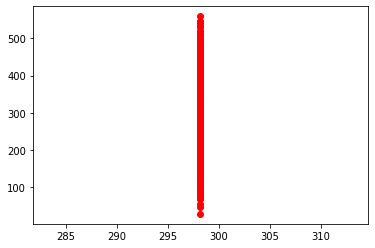

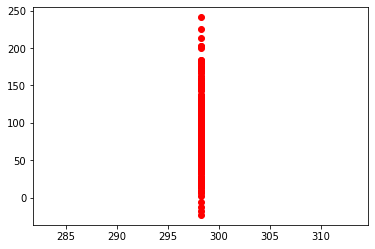

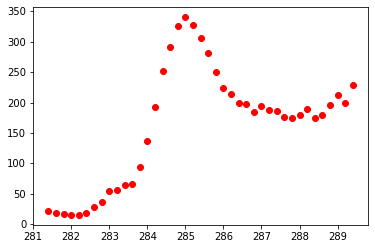

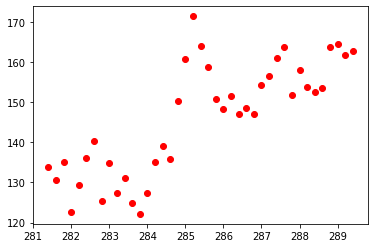

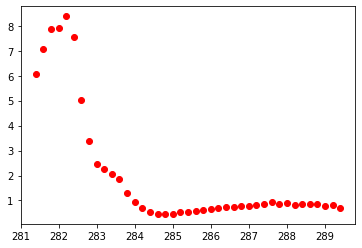

../Data/20201129/expid_TEY-argon-escan305/305.csv
Data Frame was saved as ../Data/20201129/expid_TEY-argon-escan305/../305.csv


In [ ]:
#print(EnergyOfInterest)
#print(newDF)
plt.scatter(EDFall.Energy,EDFall.I0_int,c='r') #I1
plt.show()
plt.figure
plt.scatter(EDFall.Energy,EDFall.I1_int,c='r') #I0
plt.show()
plt.figure
#plt.scatter(newDF.Energy,newDF.I1mean/newDF.I0mean,c='r')
#plt.show()
#plt.figure
plt.scatter(newDF.Energy305,newDF.I0mean305,c='r')
plt.show()
plt.figure
plt.scatter(newDF.Energy305,newDF.I1mean305,c='r')
plt.show()
plt.figure
plt.scatter(newDF.Energy305,newDF.Xas305,c='r')
plt.show()
plt.figure

srt_datasetnumber=str(datasetnumber)
print(prefix+'/'+str(datasetnumber)+'.csv')
newDF.to_csv(prefix+'/../'+str(datasetnumber)+'.csv',index=False)
print('Data Frame was saved as',prefix+'/../'+str(datasetnumber)+'.csv')

In [ ]:
#Obtain offset
Offset_key='I1_int<-40'
Offset_key='I0_int<50'
EDFoffset=EDFall.query(Offset_key).reset_index(drop=True)
print(EDFoffset.I0_int.mean())
#print(EDFoffset.I1_int.mean())

22.91669544774565
